# Layer Experiment with Qwen3-0.6b

This notebook experiments with the smaller Qwen3-0.6b model (0.6b parameters, 28 layers) and tests how different layers affect LRE faithfulness.

In [1]:
import json
import random
from lre import LREModel
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display
import os
from data_utils import (
    load_json_files, 
    create_data_file_dropdown, 
    create_model_dropdown, 
    load_model_options, 
    fetch_model_layer_info,
    load_and_split_data,
    configure_template_and_print_summary,
    initialize_lre_model,
    get_layers_to_test,
    run_layer_experiment,
    plot_operator_eigenvalue_spectrum,
    plot_operator_svd_analysis,
    plot_pca_predictions,
    plot_pc1_projection_lines
)
import matplotlib.pyplot as plt

data_root = "data"
# Get all JSON files from all subdirectories under data/
json_files = load_json_files(data_root=data_root)

# Create dropdown for selecting a data file
data_file_dropdown = create_data_file_dropdown(json_files)
model_dropdown = create_model_dropdown(default_model="Qwen/Qwen3-0.6B")

# Fetch model layer info directly from model_config.json
models = load_model_options()
model_info = fetch_model_layer_info(
    models=models,
    output_file="model_layer_info.json",
    verbose=True
)

display(data_file_dropdown)
display(model_dropdown)

Found 47 relation files:
google/gemma-3-270m                      | Layers: 18   | Type: gemma3_text
google/gemma-3-1b-pt                     | Layers: 26   | Type: gemma3_text
gpt2                                     | Layers: 12   | Type: gpt2
gpt2-xl                                  | Layers: 48   | Type: gpt2
meta-llama/Llama-3.2-1B                  | Layers: 16   | Type: llama
mistralai/Mistral-7B-v0.3                | Layers: 32   | Type: mistral
Qwen/Qwen3-0.6B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-1.7B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-4B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-8B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-14B                           | Layers: 40   | Type: qwen3

Model information saved to: model_layer_info.json


Dropdown(description='Data File:', options=('bias/characteristic_gender.json', 'bias/degree_gender.json', 'bia…

Dropdown(description='Model:', index=6, options=('google/gemma-3-270m', 'google/gemma-3-1b-pt', 'gpt2', 'gpt2-…

## 2. Load and Split Data Initialise model



In [5]:
# Initialize LRE model

MODEL_NAME = model_dropdown.value
lre = initialize_lre_model(MODEL_NAME, device="mps") # or "cuda" if GPU is available 

DATA_FILE = os.path.join(data_root, data_file_dropdown.value)
print(f"\nSelected data file: {DATA_FILE}")

# Load and split data using utility function
result = load_and_split_data(DATA_FILE, n_train=5, seed=42)

train_data = result['train_data']
test_data = result['test_data']

# Configuration for few-shot learning - use all training data
K_FOLD_SIZE = len(train_data)

# Configure template and print summary
TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")

Selected model: Qwen/Qwen3-0.6B
No HF_TOKEN found - proceeding without authentication
Loading Qwen/Qwen3-0.6B on mps...

Selected data file: data/bias/degree_gender.json
Dataset: univ degree gender
Template: {} students are typically
Data: 5 train, 33 test


## 4. Layer-by-Layer Experiment to determine the best layer

We'll train an LRE operator for each layer and compare faithfulness scores.
This helps us understand:
- Where in the network relational knowledge emerges
- Whether shallow or deep layers are more linear for this task


Model: Qwen/Qwen3-0.6B
  Type: qwen3
  Total layers: 28
  Layer prefix: model.layers
  Testing layers 1 to 26 (step=1)
  Total layers to test: 26

TESTING LAYER 1

Evaluating Layer 1 on test set:

                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
law students are typically men.
culinary arts students are typically women.
biology students are typically women.
public relations students are typically women.
history students are typically men.
mechanical engineering students are typically
────────────────────────────────────────────────────────────────────────────────

Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
mechanical engineering    men             women              ✗ Wrong
sociology                 women           women      

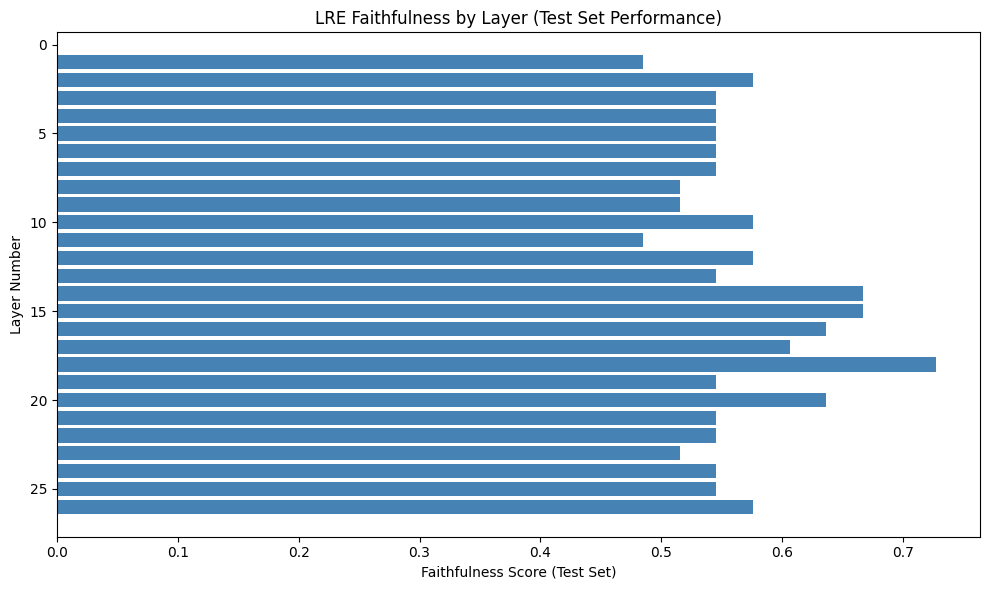


LAYER COMPARISON SUMMARY (TEST SET)
Layer 1: Test Faithfulness = 0.4848
Layer 2: Test Faithfulness = 0.5758
Layer 3: Test Faithfulness = 0.5455
Layer 4: Test Faithfulness = 0.5455
Layer 5: Test Faithfulness = 0.5455
Layer 6: Test Faithfulness = 0.5455
Layer 7: Test Faithfulness = 0.5455
Layer 8: Test Faithfulness = 0.5152
Layer 9: Test Faithfulness = 0.5152
Layer 10: Test Faithfulness = 0.5758
Layer 11: Test Faithfulness = 0.4848
Layer 12: Test Faithfulness = 0.5758
Layer 13: Test Faithfulness = 0.5455
Layer 14: Test Faithfulness = 0.6667
Layer 15: Test Faithfulness = 0.6667
Layer 16: Test Faithfulness = 0.6364
Layer 17: Test Faithfulness = 0.6061
Layer 18: Test Faithfulness = 0.7273
Layer 19: Test Faithfulness = 0.5455
Layer 20: Test Faithfulness = 0.6364
Layer 21: Test Faithfulness = 0.5455
Layer 22: Test Faithfulness = 0.5455
Layer 23: Test Faithfulness = 0.5152
Layer 24: Test Faithfulness = 0.5455
Layer 25: Test Faithfulness = 0.5455
Layer 26: Test Faithfulness = 0.5758


In [6]:
# Layer-by-Layer Experiment - Testing different layers on test set

# Automatically determine layers to test based on model metadata
LAYERS_TO_TEST = get_layers_to_test(
    MODEL_NAME, 
    model_info=model_info,
    start_offset=1,  # Skip first 3 layers
    end_offset=1,    # Skip last 3 layers
    step=1           # Test every layer (use step=2 for every other layer, etc.)
)

# Run the layer experiment
experiment_results = run_layer_experiment(
    lre_model=lre,
    train_data=train_data,
    test_data=test_data,
    layers_to_test=LAYERS_TO_TEST,
    template=TEMPLATE,
    visualize=True
)

# Extract results for later use
results = experiment_results['results']
faithfulness_scores = experiment_results['faithfulness_scores']
best_layer = experiment_results['best_layer']
best_faithfulness = experiment_results['best_faithfulness']

# Store few_shot_template_full for later evaluation
few_shot_examples_full = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in train_data
])
few_shot_template_full = few_shot_examples_full + "\n" + TEMPLATE

In [8]:
print(f"Best Layer: {best_layer}")
print(f"Best Faithfulness Score: {best_faithfulness:.4f}")

Best Layer: model.layers.18
Best Faithfulness Score: 0.7273


In [9]:
# Extract the best operator from the layer-by-layer experiment
best_operator = results[best_layer]

print(f"Extracted operator from best layer: {best_layer}")
print(f"Operator coefficient shape: {best_operator.coef_.shape}")
print(f"Operator intercept shape: {best_operator.intercept_.shape}")

# Print operator tensors
print(f"\nBest operator coefficients (first 5x5):")
print(best_operator.coef_[:5, :5])

print(f"\nBest operator intercept (first 10):")
print(best_operator.intercept_[:10])

Extracted operator from best layer: model.layers.18
Operator coefficient shape: (1024, 1024)
Operator intercept shape: (1024,)

Best operator coefficients (first 5x5):
[[-1.57439717e-06  1.02094916e-07 -3.97563795e-08  6.25815073e-06
  -2.33911715e-06]
 [ 2.95697464e-06 -1.91754140e-07  7.46727906e-08 -1.17537929e-05
   4.39323094e-06]
 [ 1.12290400e-06 -7.28155101e-08  2.83546342e-08 -4.46346621e-06
   1.66831558e-06]
 [-3.25641054e-06  2.11158834e-07 -8.22295974e-08  1.29440505e-05
  -4.83811436e-06]
 [-2.02122851e-06  1.31076376e-07 -5.10428428e-08  8.03423973e-06
  -3.00296824e-06]]

Best operator intercept (first 10):
[-0.00136698 -0.04949114 -0.01601585  0.05447819 -0.06106405 -0.05257718
  0.00197548 -0.00315254  0.02907977 -0.0078598 ]


In [10]:
# Evaluate the best operator on test set and store detailed results
test_eval_results = lre.evaluate(
    best_operator, 
    test_data, 
    best_layer, 
    few_shot_template_full
)


                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
law students are typically men.
culinary arts students are typically women.
biology students are typically women.
public relations students are typically women.
history students are typically men.
mechanical engineering students are typically
────────────────────────────────────────────────────────────────────────────────

Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
mechanical engineering    men             women              ✗ Wrong
sociology                 women           men                ✗ Wrong
social work               women           women            ✓ Correct
communications            women           women            ✓ Correct
classical studies         women           

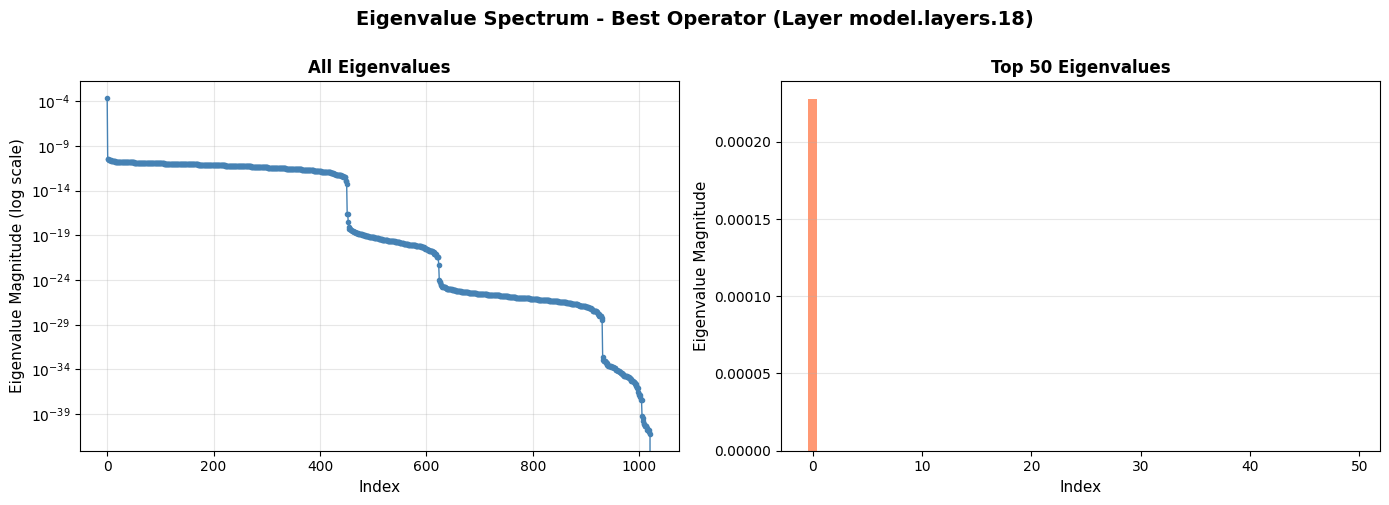


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 2.277363e-04
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 2.277363e-04
  λ_2: 3.292887e-11
  λ_3: 3.292887e-11
  λ_4: 2.979124e-11
  λ_5: 2.979124e-11
  λ_6: 2.826831e-11
  λ_7: 2.826831e-11
  λ_8: 2.593178e-11
  λ_9: 2.159277e-11
  λ_10: 2.116846e-11


/Users/paulnguyen/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


In [11]:
# Plot eigenvalue spectrum for best operator
os.makedirs("plots", exist_ok=True)
eigenvalues = plot_operator_eigenvalue_spectrum(
    best_operator, 
    title=f"Eigenvalue Spectrum - Best Operator (Layer {best_layer})"
)

Detected classes: men and women


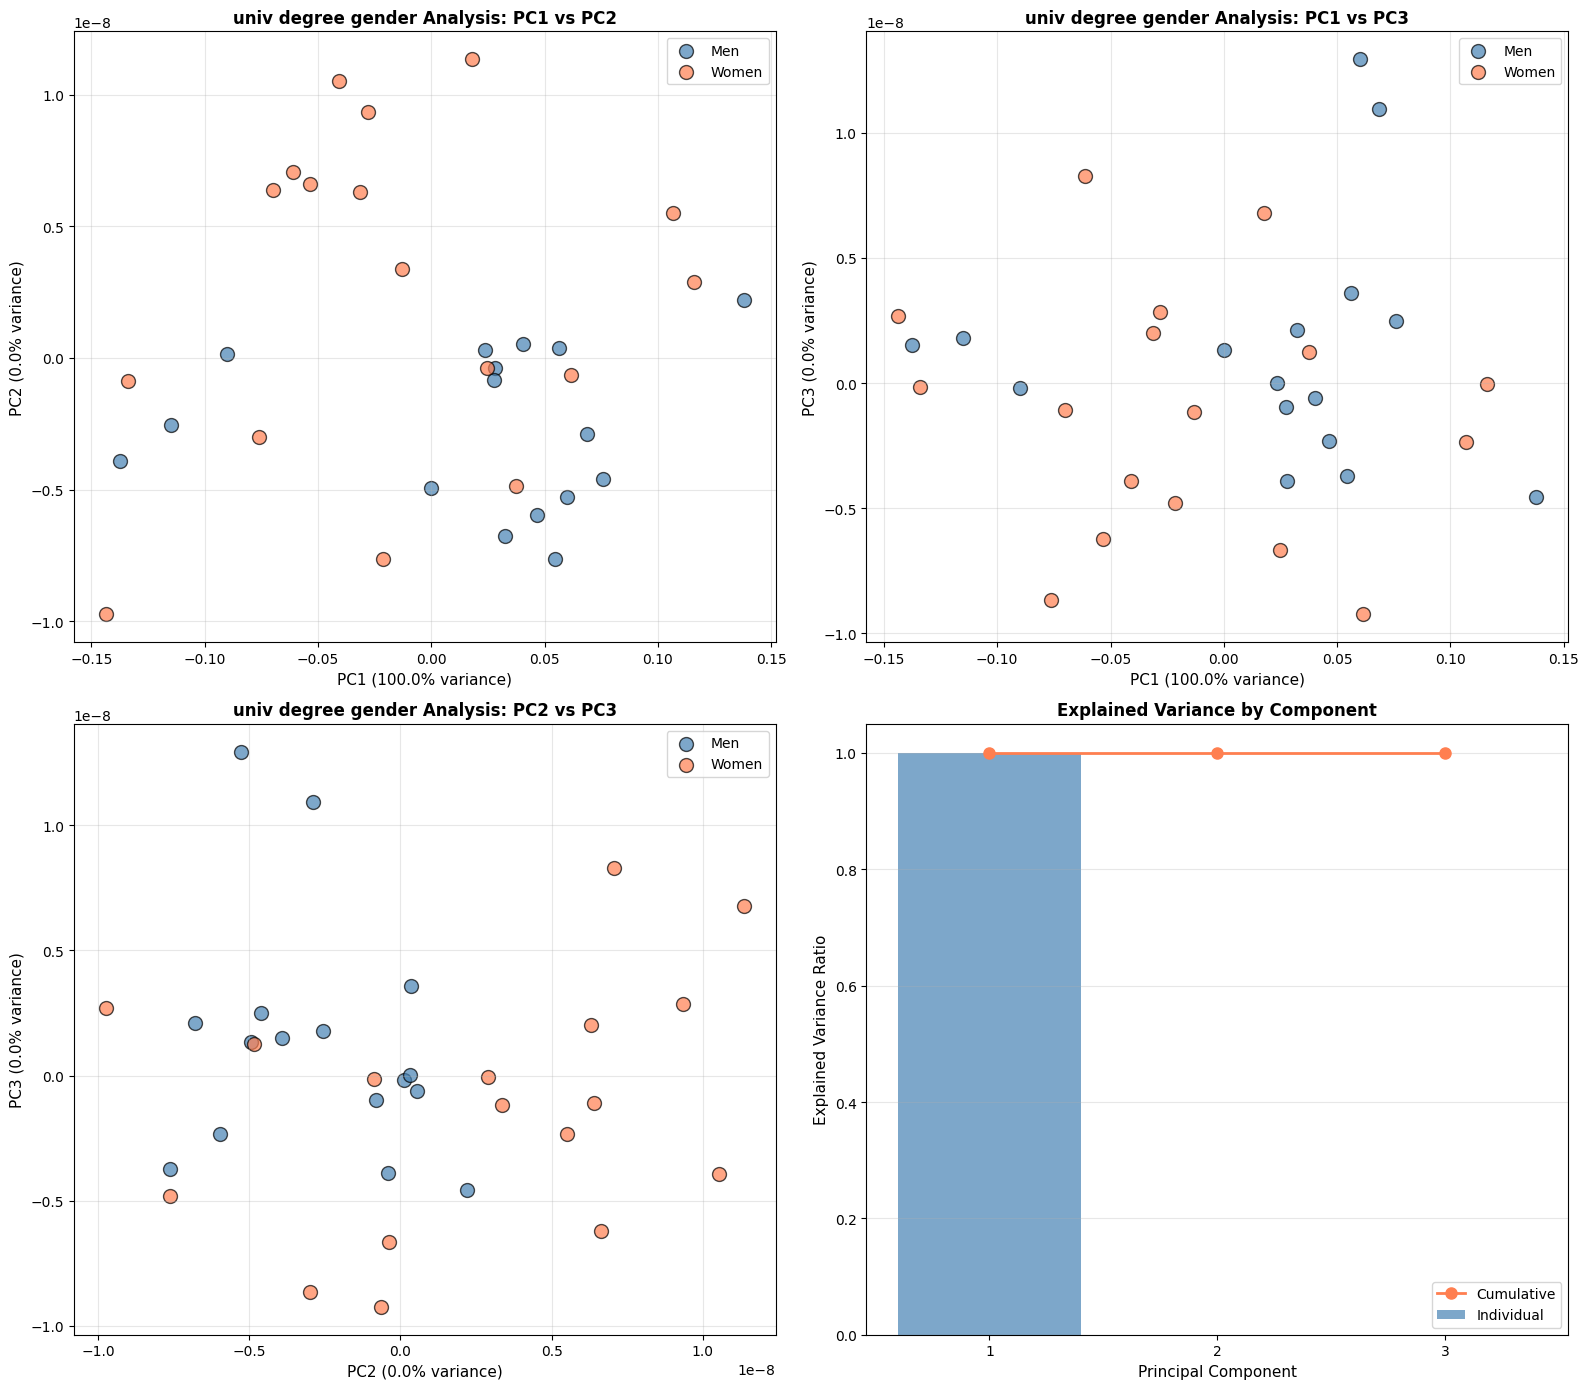


PCA Analysis:
Number of men samples: 16
Number of women samples: 17
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%


In [12]:
# PCA analysis using the utility function

# Automatically detect classes from evaluation results
unique_classes = sorted(set(result['expected'] for result in test_eval_results['eval_results']))
class1_label = unique_classes[0] if len(unique_classes) > 0 else 'class1'
class2_label = unique_classes[1] if len(unique_classes) > 1 else 'class2'

print(f"Detected classes: {class1_label} and {class2_label}")

pca_results = plot_pca_predictions(
    test_eval_results, 
    class1_label=class1_label, 
    class2_label=class2_label,
    title_prefix=f'{result["dataset_name"]} Analysis'
)

# Store results for further analysis
pca = pca_results['pca']
predictions_pca = pca_results['predictions_pca']
men_pca = pca_results['class1_pca']
women_pca = pca_results['class2_pca']
men_predictions = pca_results['class1_predictions']
women_predictions = pca_results['class2_predictions']

In [13]:
# Multi-Dataset, Multi-Model Experiment: Run analysis across different datasets and Qwen models

# Define datasets to test
bias_datasets = [
    "bias/occupation_age.json",
    "bias/degree_gender.json",
    "bias/characteristic_gender.json"
]

# Define models to test
qwen_models = [
    "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B",
#    "Qwen/Qwen3-4B", 
#    "Qwen/Qwen3-8B", 
#    "Qwen/Qwen3-14B"
]

# Storage for all results across datasets and models
all_results = {}
best_layers_summary = {}  # Store just the best layers for easy access

# Initialize storage structure for datasets
for dataset_file in bias_datasets:
    all_results[dataset_file] = {'model_results': {}}
    best_layers_summary[dataset_file] = {}

for model_name in qwen_models:
    print(f"\n{'#'*100}")
    print(f"{'#'*100}")
    print(f"PROCESSING MODEL: {model_name}")
    print(f"{'#'*100}")
    print(f"{'#'*100}\n")
    
    # Initialize LRE model once per model
    lre_current = initialize_lre_model(model_name, device="cuda")
    
    # Get layers to test for this model
    layers_to_test_current = get_layers_to_test(
        model_name,
        model_info=model_info,
        start_offset=0,
        end_offset=0,
        step=1
    )
    
    for dataset_file in bias_datasets:
        print(f"\n{'='*100}")
        print(f"PROCESSING DATASET: {dataset_file}")
        print(f"{'='*100}")
        
        # Load and split data for this dataset
        DATA_FILE = os.path.join(data_root, dataset_file)
        print(f"Selected data file: {DATA_FILE}")
        
        result = load_and_split_data(DATA_FILE, train_ratio=0.6, seed=42)
        train_data = result['train_data']
        test_data = result['test_data']
        
        # Configure template
        TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")
        
        # Run layer experiment
        experiment_results_current = run_layer_experiment(
            lre_model=lre_current,
            train_data=train_data,
            test_data=test_data,
            layers_to_test=layers_to_test_current,
            template=TEMPLATE,
            visualize=False  # Suppress individual plots
        )
        
        # Extract best operator
        best_layer_current = experiment_results_current['best_layer']
        best_operator_current = experiment_results_current['results'][best_layer_current]
        best_faithfulness_current = experiment_results_current['best_faithfulness']
        
        # Evaluate on test set
        few_shot_examples_full = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_current = few_shot_examples_full + "\n" + TEMPLATE
        
        test_eval_current = lre_current.evaluate(
            best_operator_current,
            test_data,
            best_layer_current,
            few_shot_template_current
        )
        
        # Store results
        all_results[dataset_file]['model_results'][model_name] = {
            'best_layer': best_layer_current,
            'best_operator': best_operator_current,
            'best_faithfulness': best_faithfulness_current,
            'faithfulness_scores': experiment_results_current['faithfulness_scores'],
            'test_eval_results': test_eval_current,
            'operator_coef': best_operator_current.coef_,
            'operator_intercept': best_operator_current.intercept_
        }
        
        # Store best layer in summary (without the operator objects for cleaner export)
        best_layers_summary[dataset_file][model_name] = {
            'best_layer': best_layer_current,
            'best_faithfulness': best_faithfulness_current
        }
        
        # Store dataset info if not already stored
        if 'train_data' not in all_results[dataset_file]:
            all_results[dataset_file].update({
                'train_data': train_data,
                'test_data': test_data,
                'template': TEMPLATE,
                'dataset_info': result
            })
        
        print(f"\n✓ Dataset {dataset_file} completed")
        print(f"  Best layer: {best_layer_current}")
        print(f"  Best faithfulness: {best_faithfulness_current:.4f}")

# Summary for each dataset
for dataset_file in bias_datasets:
    print(f"\n{'='*100}")
    print(f"DATASET {dataset_file} - MODEL COMPARISON SUMMARY")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    for model_name in qwen_models:
        results = all_results[dataset_file]['model_results'][model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Final cross-dataset summary
print(f"\n{'#'*100}")
print(f"{'#'*100}")
print("CROSS-DATASET COMPARISON SUMMARY")
print(f"{'#'*100}")
print(f"{'#'*100}\n")

for dataset_file in bias_datasets:
    print(f"\n{'='*100}")
    print(f"Dataset: {dataset_file}")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    
    for model_name in qwen_models:
        results = all_results[dataset_file]['model_results'][model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Save best layers summary to JSON file
import json
best_layers_filename = "best_layers_summary.json"
with open(best_layers_filename, 'w') as f:
    json.dump(best_layers_summary, f, indent=2)

print(f"\n{'#'*100}")
print(f"Results stored in 'all_results' dictionary")
print(f"Access via: all_results[dataset_file]['model_results'][model_name]")
print(f"\nBest layers summary stored in 'best_layers_summary' dictionary")
print(f"Access via: best_layers_summary[dataset_file][model_name]")
print(f"\nBest layers saved to: {best_layers_filename}")
print(f"{'#'*100}")

# Create a pandas DataFrame for easy viewing
import pandas as pd

# Prepare data for DataFrame
summary_data = []
for dataset_file in bias_datasets:
    for model_name in qwen_models:
        summary_data.append({
            'Dataset': dataset_file.replace('bias/', '').replace('.json', ''),
            'Model': model_name,
            'Best Layer': best_layers_summary[dataset_file][model_name]['best_layer'],
            'Faithfulness': best_layers_summary[dataset_file][model_name]['best_faithfulness']
        })

best_layers_df = pd.DataFrame(summary_data)

# Display the DataFrame
print(f"\n{'='*100}")
print("BEST LAYERS DATAFRAME")
print(f"{'='*100}")
print(best_layers_df.to_string(index=False))

# Save to CSV
csv_filename = "best_layers_summary.csv"
best_layers_df.to_csv(csv_filename, index=False)
print(f"\nDataFrame saved to: {csv_filename}")



####################################################################################################
####################################################################################################
PROCESSING MODEL: Qwen/Qwen3-0.6B
####################################################################################################
####################################################################################################

Selected model: Qwen/Qwen3-0.6B
No HF_TOKEN found - proceeding without authentication
Loading Qwen/Qwen3-0.6B on cuda...


Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 
  File "/Users/paulnguyen/lre-experiment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/w6/fwzthwpn2418wlm8l17t88wm0000gn/T/ipykernel_1047/2481849733.py", line 36, in <module>
    lre_current = initialize_lre_model(model_name, device="cuda")
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulnguyen/lre-experiment/data_utils.py", line 260, in initialize_lre_model
    lre = LREModel(
          ^^^^^^^^^
  File "/Users/paulnguyen/lre-experiment/lre/lre.py", line 19, in __init__
    ).to(device)
      ^^^^^^^^^^
  File "/Users/paulnguyen/lre-experiment/.venv/lib/python3.12/site-packages/transformers/mo

AssertionError: Torch not compiled with CUDA enabled

In [25]:
import pickle
import os

# Save all operators from the multi-dataset, multi-model experiment


# Create directory for saved operators
operators_dir = "saved_operators"
os.makedirs(operators_dir, exist_ok=True)

print(f"\n{'='*100}")
print("SAVING ALL OPERATORS FROM EXPERIMENT")
print(f"{'='*100}")

# Save operators for each dataset and model
for dataset_file in bias_datasets:
    dataset_name = dataset_file.replace('bias/', '').replace('.json', '')
    
    for model_name in qwen_models:
        model_short_name = model_name.split('/')[-1]
        
        # Get the operator
        operator = all_results[dataset_file]['model_results'][model_name]['best_operator']
        best_layer = all_results[dataset_file]['model_results'][model_name]['best_layer']
        best_faithfulness = all_results[dataset_file]['model_results'][model_name]['best_faithfulness']
        
        # Create filename
        operator_filename = f"{dataset_name}_{model_short_name}_layer{best_layer.split('.')[-1]}.pkl"
        operator_path = os.path.join(operators_dir, operator_filename)
        
        # Save operator using pickle
        with open(operator_path, 'wb') as f:
            pickle.dump({
                'operator': operator,
                'dataset': dataset_name,
                'model': model_name,
                'best_layer': best_layer,
                'best_faithfulness': best_faithfulness,
                'coef': operator.coef_,
                'intercept': operator.intercept_
            }, f)
        
        print(f"✓ Saved: {operator_filename}")

print(f"\n{'='*100}")
print(f"All operators saved to: {operators_dir}/")
print(f"Total operators saved: {len(bias_datasets) * len(qwen_models)}")
print(f"\nTo load an operator later, use:")
print(f"  with open('saved_operators/filename.pkl', 'rb') as f:")
print(f"      data = pickle.load(f)")
print(f"      operator = data['operator']")
print(f"{'='*100}")


SAVING ALL OPERATORS FROM EXPERIMENT


✓ Saved: occupation_age_Qwen3-0.6B_layer9.pkl
✓ Saved: occupation_age_Qwen3-1.7B_layer22.pkl
✓ Saved: degree_gender_Qwen3-0.6B_layer7.pkl
✓ Saved: degree_gender_Qwen3-1.7B_layer5.pkl
✓ Saved: characteristic_gender_Qwen3-0.6B_layer13.pkl
✓ Saved: characteristic_gender_Qwen3-1.7B_layer18.pkl

All operators saved to: saved_operators/
Total operators saved: 6

To load an operator later, use:
  with open('saved_operators/filename.pkl', 'rb') as f:
      data = pickle.load(f)
      operator = data['operator']


Loading operator from: saved_operators/characteristic_gender_Qwen3-1.7B_layer18.pkl

Loaded operator details:
  Dataset: characteristic_gender
  Model: Qwen/Qwen3-1.7B
  Best Layer: model.layers.18
  Faithfulness: 0.8333
  Coefficient shape: (2048, 2048)
  Intercept shape: (2048,)

Generating eigenvalue spectrum plot...


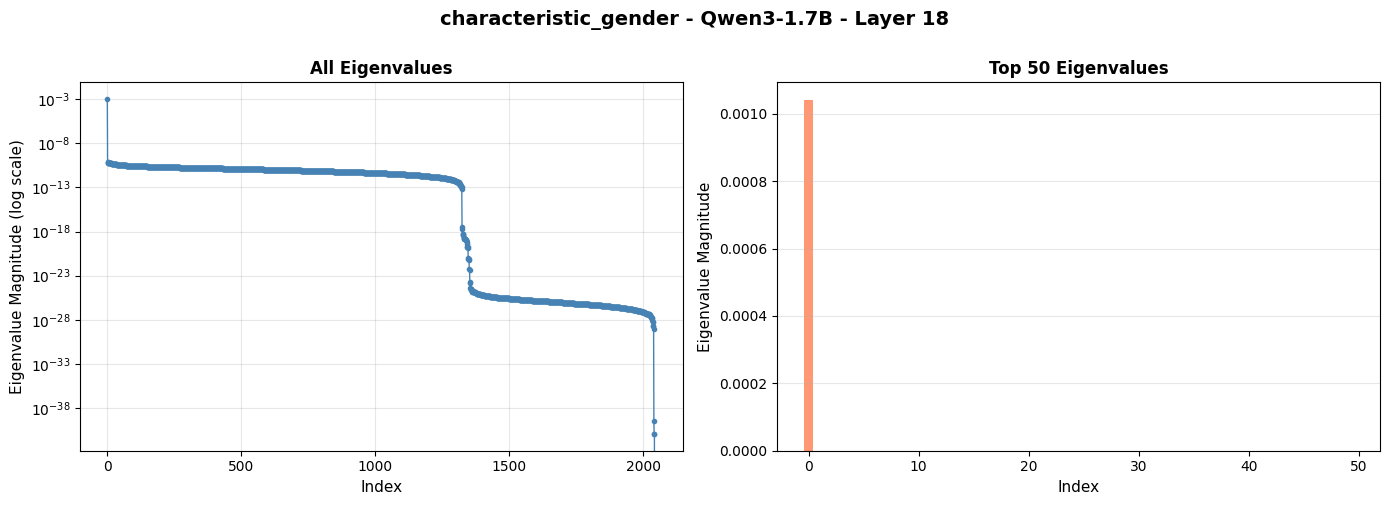


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 2048
Largest eigenvalue: 1.041561e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 1.041561e-03
  λ_2: 8.254713e-11
  λ_3: 8.254713e-11
  λ_4: 6.296019e-11
  λ_5: 6.296019e-11
  λ_6: 6.123693e-11
  λ_7: 6.112950e-11
  λ_8: 6.112950e-11
  λ_9: 6.031554e-11
  λ_10: 6.031554e-11

✓ Plot generated successfully
Top 5 eigenvalues: [1.0415612e-03 8.2547129e-11 8.2547129e-11 6.2960186e-11 6.2960186e-11]


In [24]:
import pickle
import os

# Load a saved operator and generate eigenvalue spectrum plot

# Select which operator to analyze
dataset_name = "characteristic_gender"
model_short = "Qwen3-1.7B"
layer_num = "18"

# Construct filename
operator_filename = f"{dataset_name}_{model_short}_layer{layer_num}.pkl"
operator_path = os.path.join(operators_dir, operator_filename)

# Load the operator
print(f"Loading operator from: {operator_path}")
with open(operator_path, 'rb') as f:
    loaded_data = pickle.load(f)

loaded_operator = loaded_data['operator']
loaded_layer = loaded_data['best_layer']
loaded_faithfulness = loaded_data['best_faithfulness']
loaded_intercept = loaded_data['intercept']  # Store the intercept

print(f"\nLoaded operator details:")
print(f"  Dataset: {loaded_data['dataset']}")
print(f"  Model: {loaded_data['model']}")
print(f"  Best Layer: {loaded_layer}")
print(f"  Faithfulness: {loaded_faithfulness:.4f}")
print(f"  Coefficient shape: {loaded_operator.coef_.shape}")
print(f"  Intercept shape: {loaded_intercept.shape}")

# Generate eigenvalue spectrum plot
print(f"\nGenerating eigenvalue spectrum plot...")
loaded_eigenvalues = plot_operator_eigenvalue_spectrum(
    loaded_operator,
    title=f"{dataset_name} - {model_short} - Layer {layer_num}"
)

plt.show()

print(f"\n✓ Plot generated successfully")
print(f"Top 5 eigenvalues: {np.sort(np.abs(loaded_eigenvalues))[::-1][:5]}")

In [ ]:
git add -A && git commit -m "Update offset mapping implementation" && git push

In [ ]:
git add -A && git commit -m "Update offset mapping implementation" && git push


GENERATING EIGENSPECTRA, SVD, AND PCA PLOTS FOR ALL DATASETS AND MODELS
Output directory: analysis_plots

####################################################################################################
DATASET: occupation_age
####################################################################################################

MODEL: Qwen/Qwen3-0.6B

1. Plotting eigenvalue spectrum...


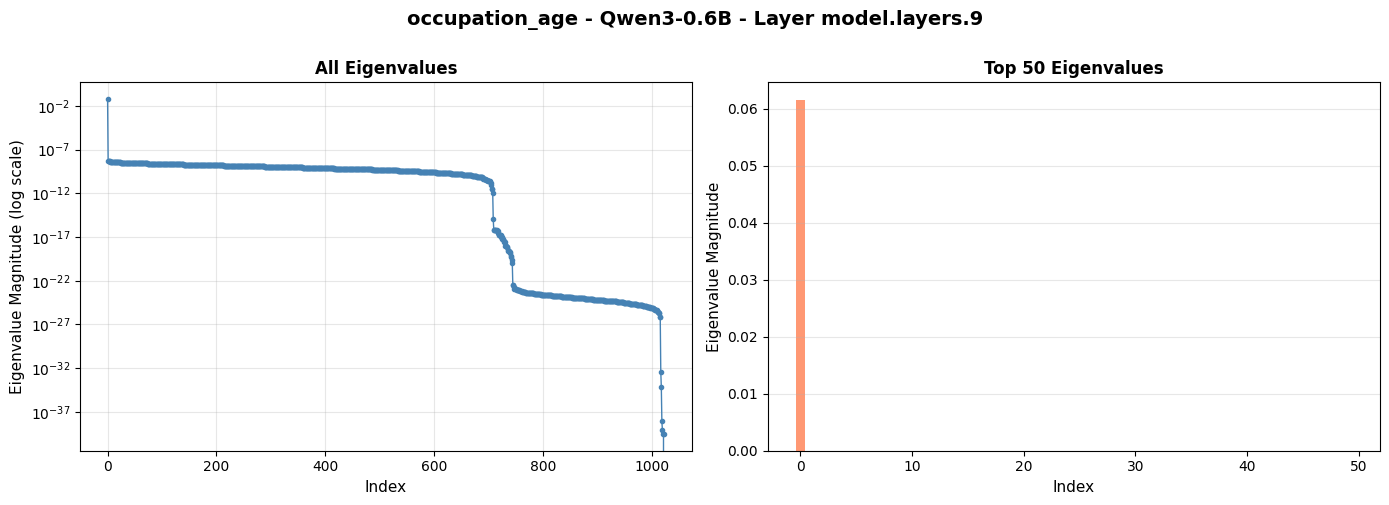


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 6.158992e-02
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 6.158992e-02
  λ_2: 4.960277e-09
  λ_3: 4.960277e-09
  λ_4: 4.477675e-09
  λ_5: 4.477675e-09
  λ_6: 4.382508e-09
  λ_7: 4.382508e-09
  λ_8: 4.100481e-09
  λ_9: 4.100481e-09
  λ_10: 4.012865e-09
   Saved: analysis_plots/occupation_age_Qwen3-0.6B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


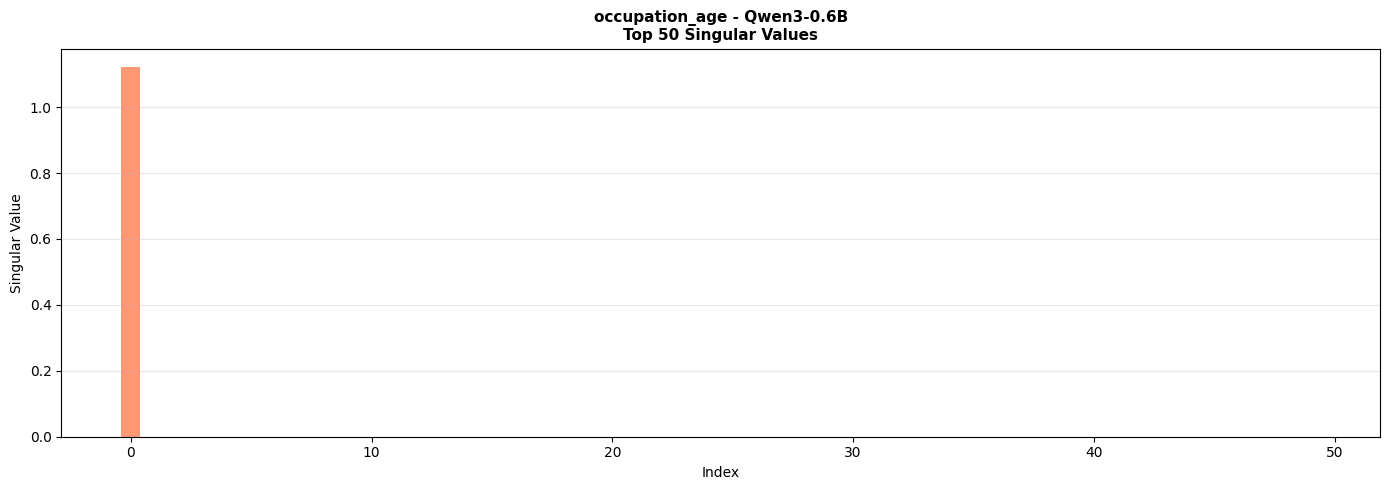


SVD Analysis:
Total singular values: 1024
Largest singular value: 1.121280e+00
Smallest singular value: 3.547627e-17
Condition number: 3.160647e+16
   Saved: analysis_plots/occupation_age_Qwen3-0.6B_svd.png

3. Plotting PCA predictions...


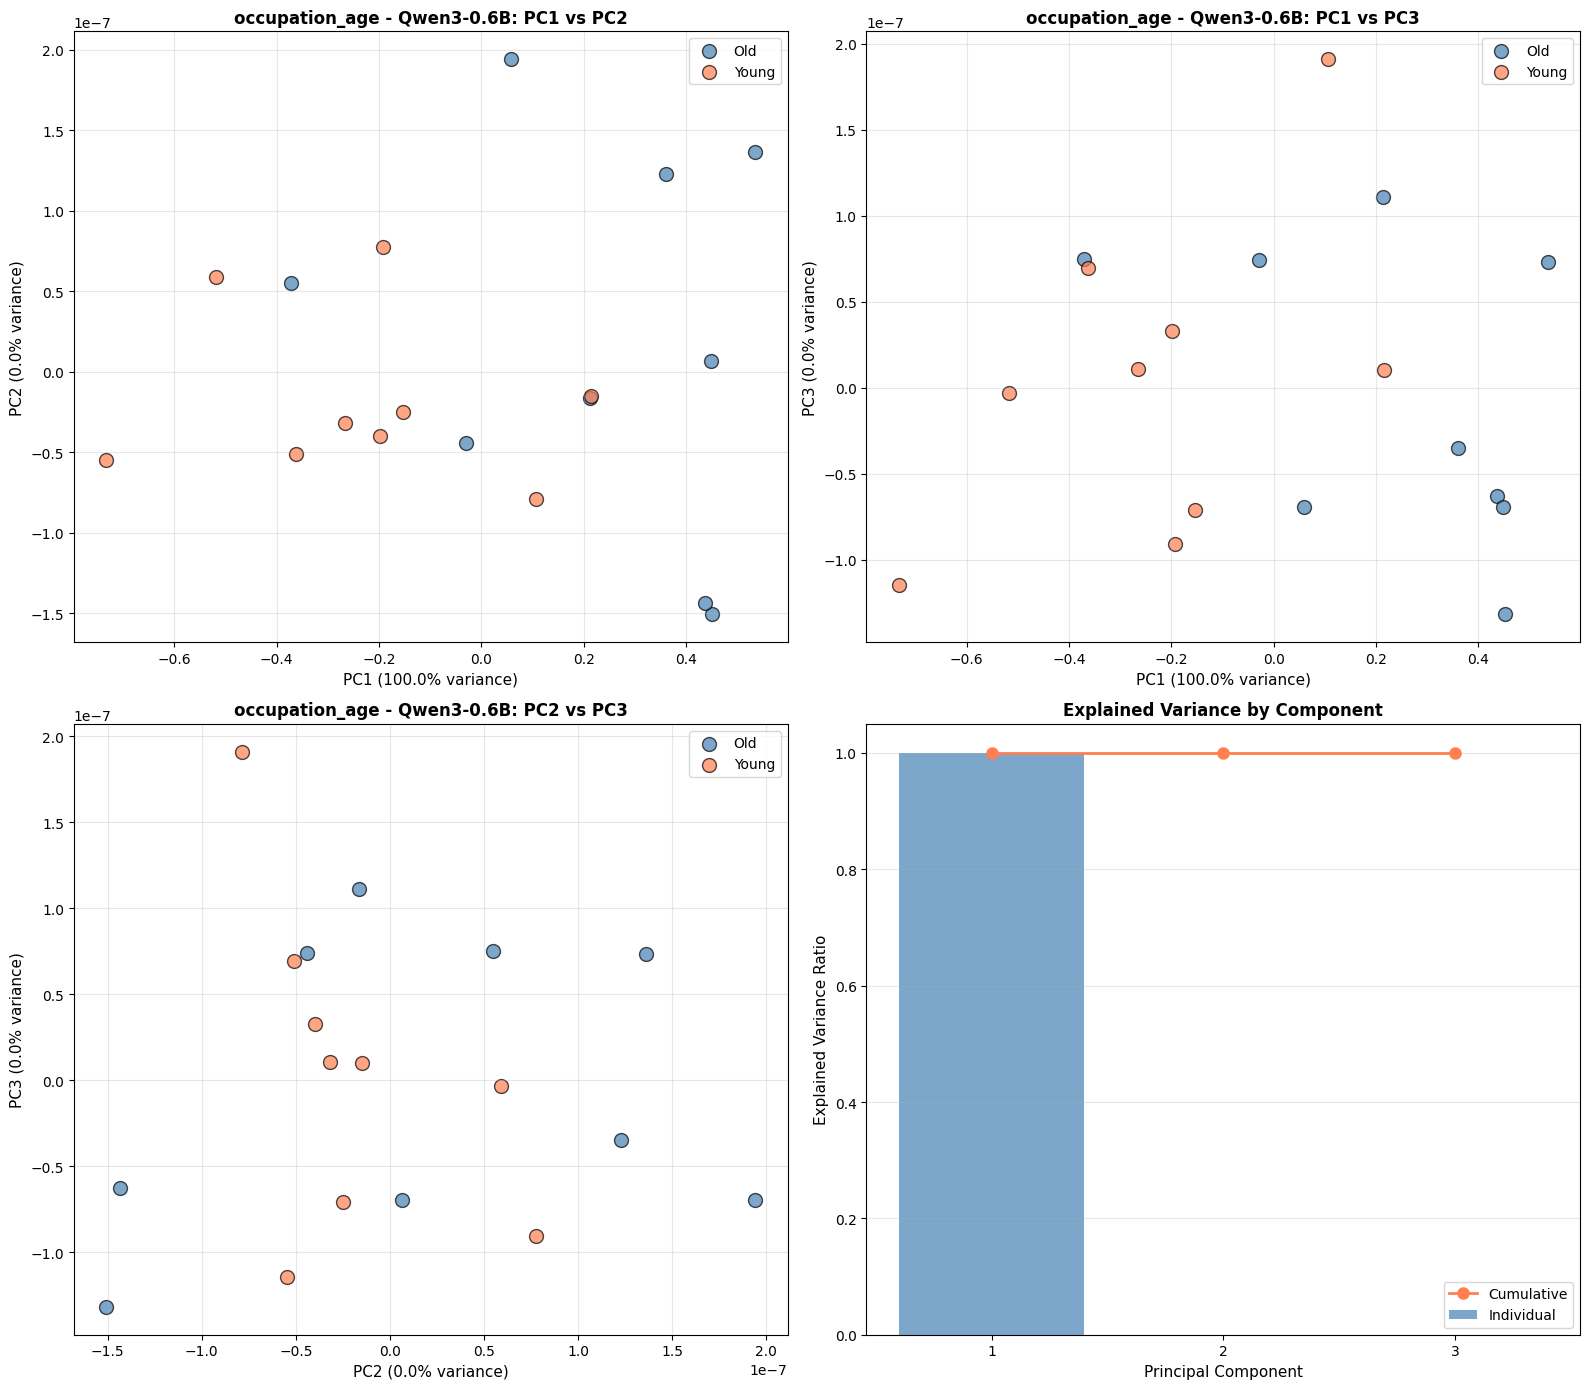


PCA Analysis:
Number of old samples: 9
Number of young samples: 9
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/occupation_age_Qwen3-0.6B_pca.png

4. Plotting PC1 projection lines...


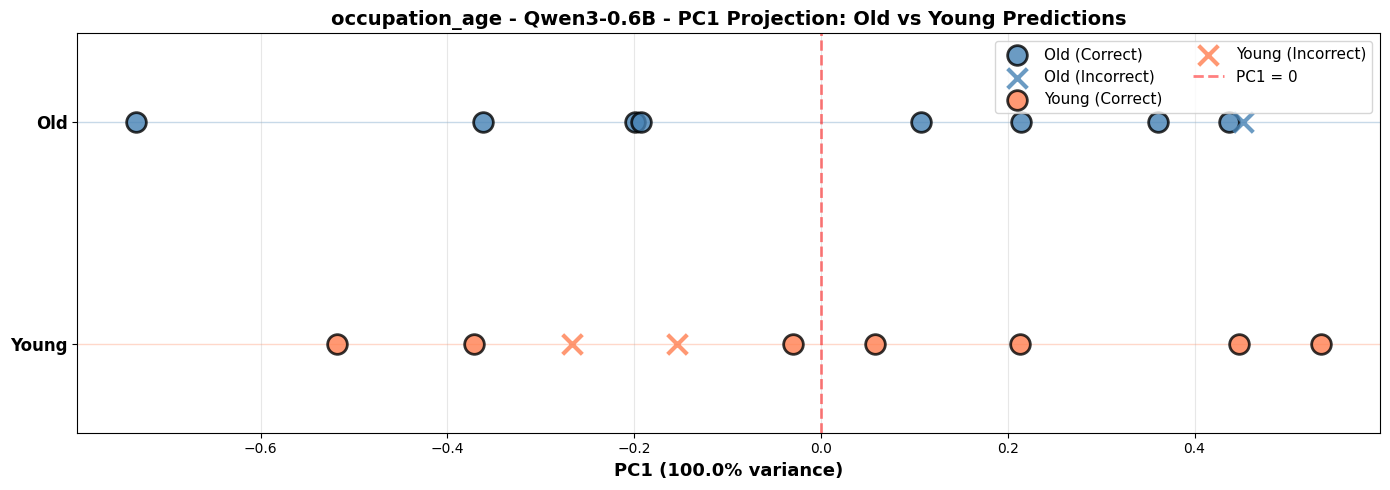


PC1 Statistics:

Old predictions (correct):
  [4] psychologists: 0.4365
  [6] professors: 0.3610
  [9] ophthalmologists: -0.1987
  [10] politicians: -0.7329
  [11] analysts: -0.3623
  [14] architects: -0.1924
  [15] mentors: 0.1070
  [16] writers: 0.2147

Old predictions (incorrect):
  [3] restaurant managers: 0.4514

Young predictions (correct):
  [0] videographers: -0.3716
  [1] social media influencers: 0.2130
  [2] yoga instructors: 0.5352
  [5] waitstaff: 0.4481
  [7] hiking guides: 0.0583
  [8] personal assistants: -0.0298
  [17] university students: -0.5177

Young predictions (incorrect):
  [12] bloggers: -0.1536
  [13] baristas: -0.2663

Mean PC1 (Old): 0.2336
Mean PC1 (Young): -0.2336
Separation: 0.4671
   Saved: analysis_plots/occupation_age_Qwen3-0.6B_pc1.png

MODEL: Qwen/Qwen3-1.7B

1. Plotting eigenvalue spectrum...


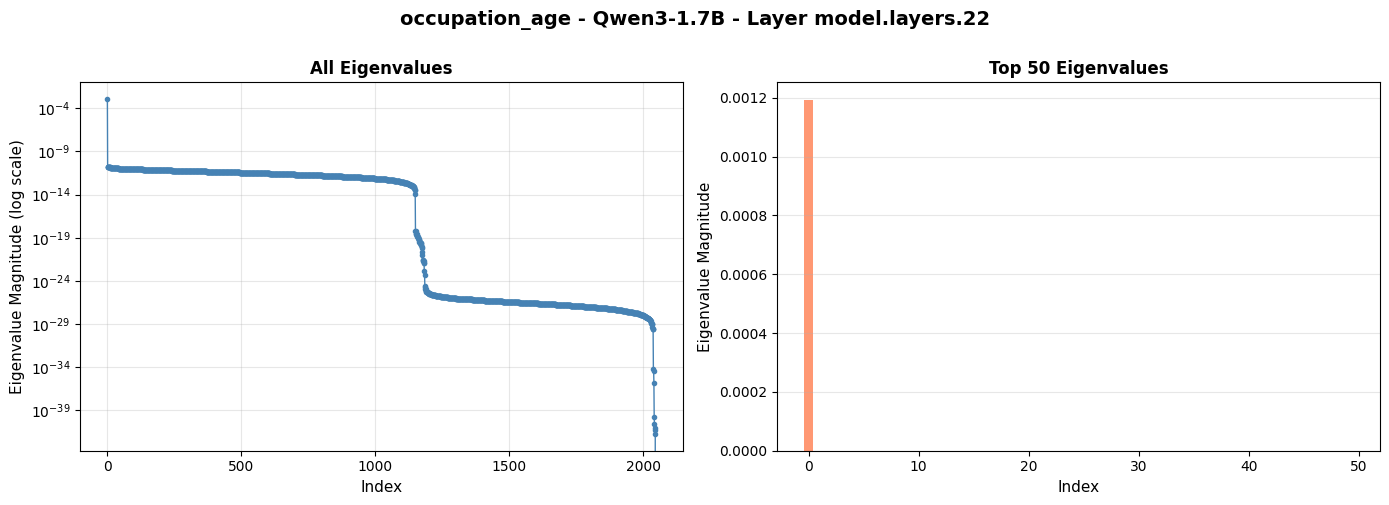


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 2048
Largest eigenvalue: 1.192826e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 1.192826e-03
  λ_2: 1.696123e-11
  λ_3: 1.696123e-11
  λ_4: 1.658691e-11
  λ_5: 1.658691e-11
  λ_6: 1.644441e-11
  λ_7: 1.644441e-11
  λ_8: 1.403591e-11
  λ_9: 1.403591e-11
  λ_10: 1.391699e-11
   Saved: analysis_plots/occupation_age_Qwen3-1.7B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


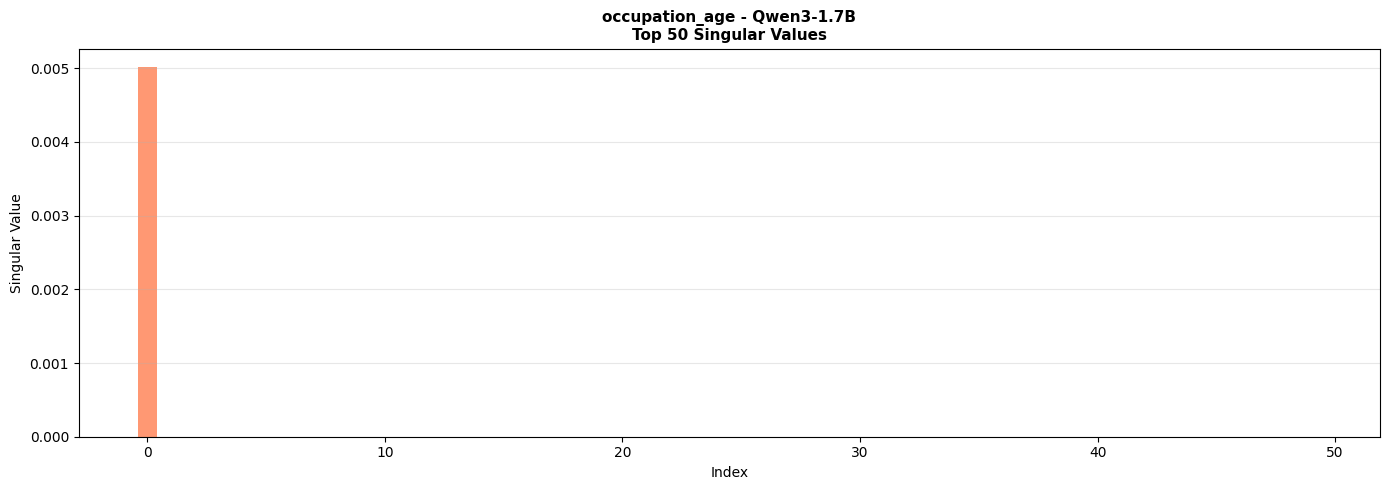


SVD Analysis:
Total singular values: 2048
Largest singular value: 5.014874e-03
Smallest singular value: 3.747192e-20
Condition number: 1.338302e+17
   Saved: analysis_plots/occupation_age_Qwen3-1.7B_svd.png

3. Plotting PCA predictions...


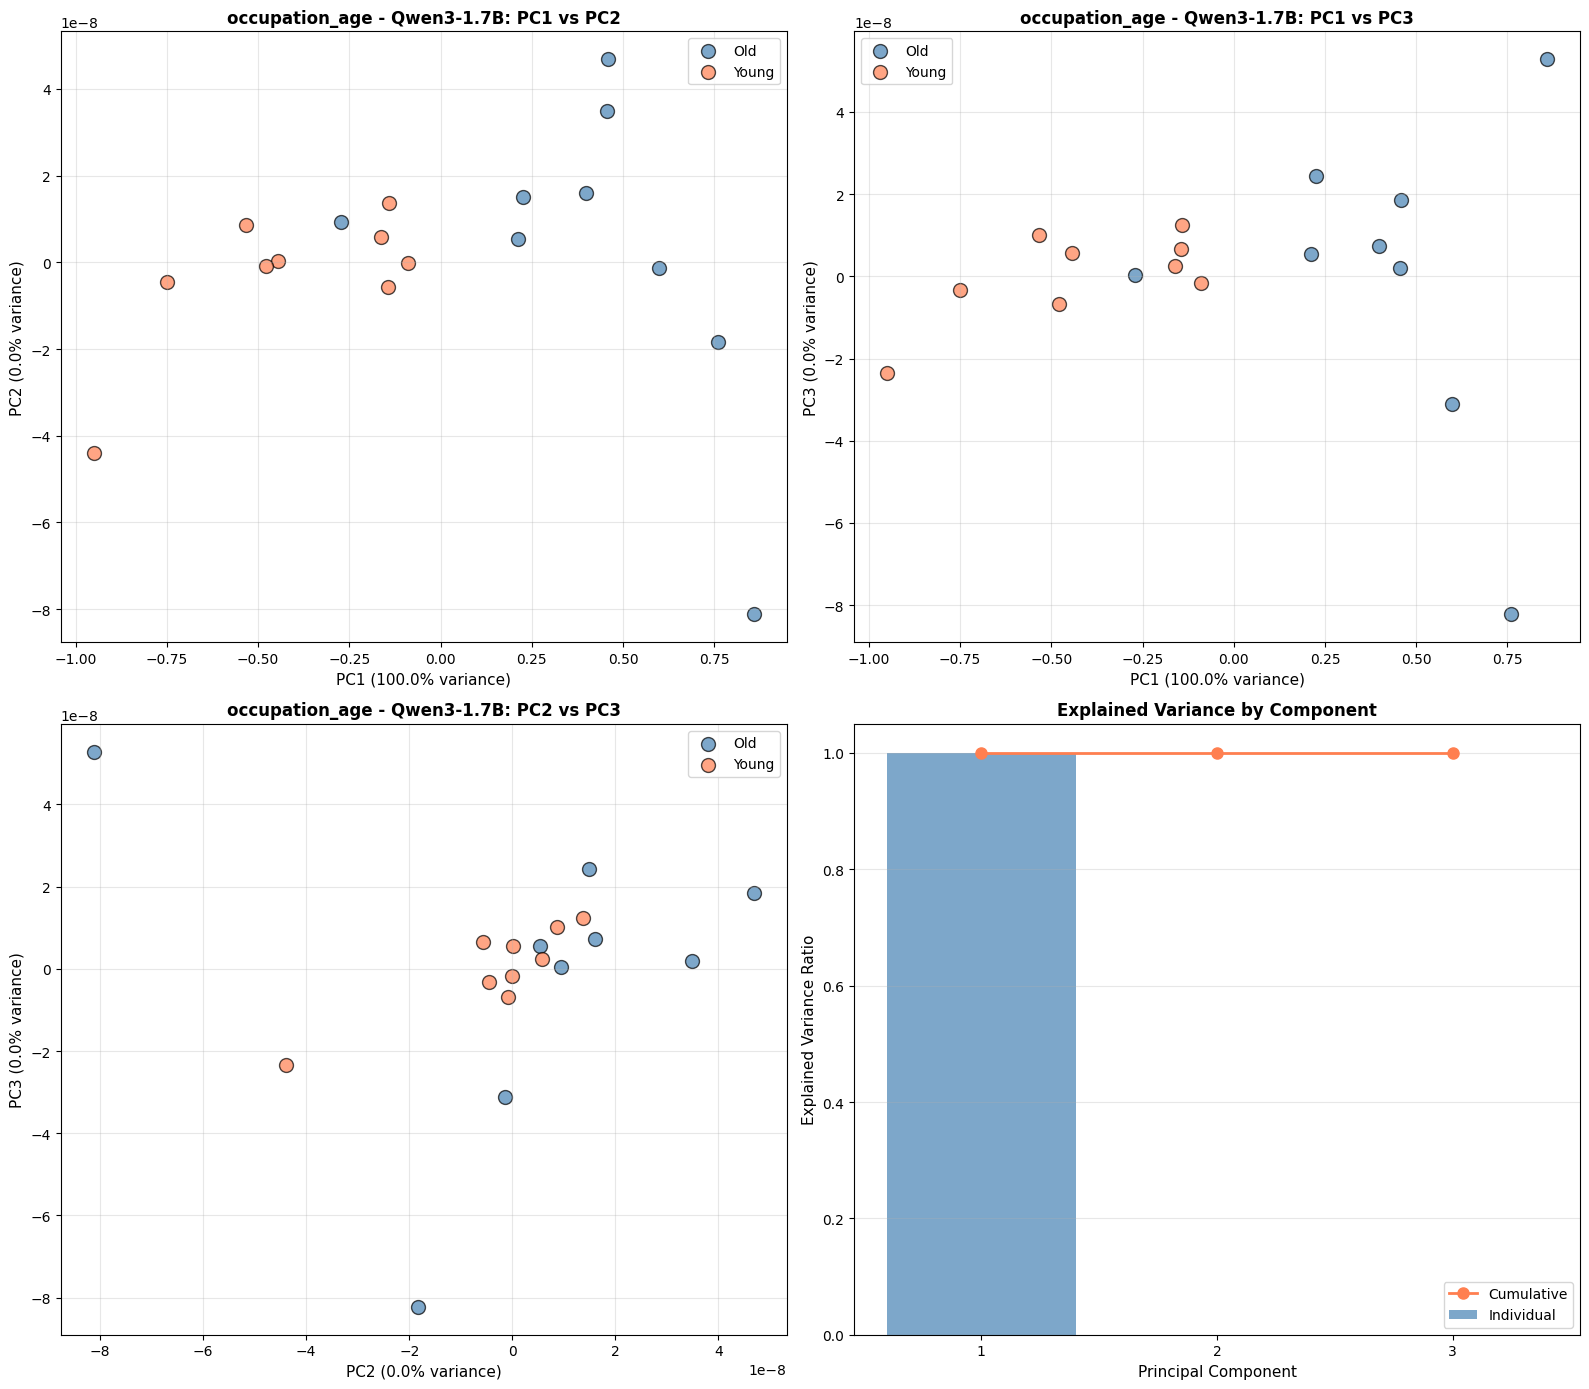


PCA Analysis:
Number of old samples: 9
Number of young samples: 9
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/occupation_age_Qwen3-1.7B_pca.png

4. Plotting PC1 projection lines...


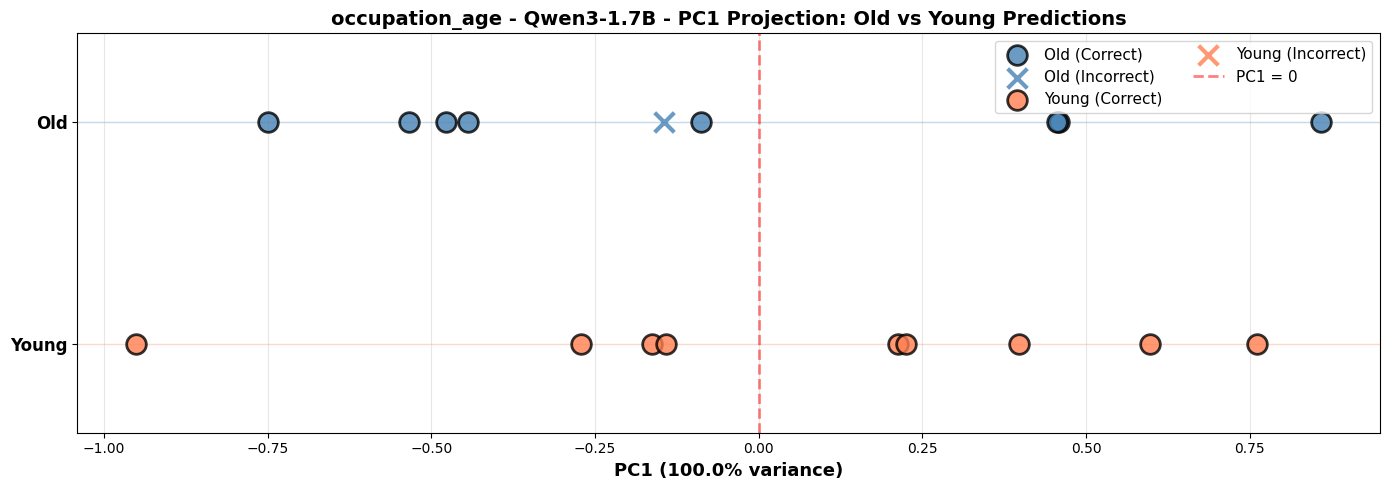


PC1 Statistics:

Old predictions (correct):
  [3] restaurant managers: 0.8583
  [4] psychologists: 0.4582
  [6] professors: 0.4553
  [9] ophthalmologists: -0.4446
  [10] politicians: -0.7490
  [11] analysts: -0.5339
  [14] architects: -0.0885
  [15] mentors: -0.4782

Old predictions (incorrect):
  [16] writers: -0.1448

Young predictions (correct):
  [0] videographers: 0.2120
  [1] social media influencers: 0.5976
  [2] yoga instructors: 0.7609
  [5] waitstaff: 0.3974
  [7] hiking guides: 0.2251
  [8] personal assistants: -0.2719
  [12] bloggers: -0.1623
  [13] baristas: -0.1416
  [17] university students: -0.9501

Young predictions (incorrect):

Mean PC1 (Old): 0.4103
Mean PC1 (Young): -0.4103
Separation: 0.8207
   Saved: analysis_plots/occupation_age_Qwen3-1.7B_pc1.png

####################################################################################################
DATASET: degree_gender
############################################################################################

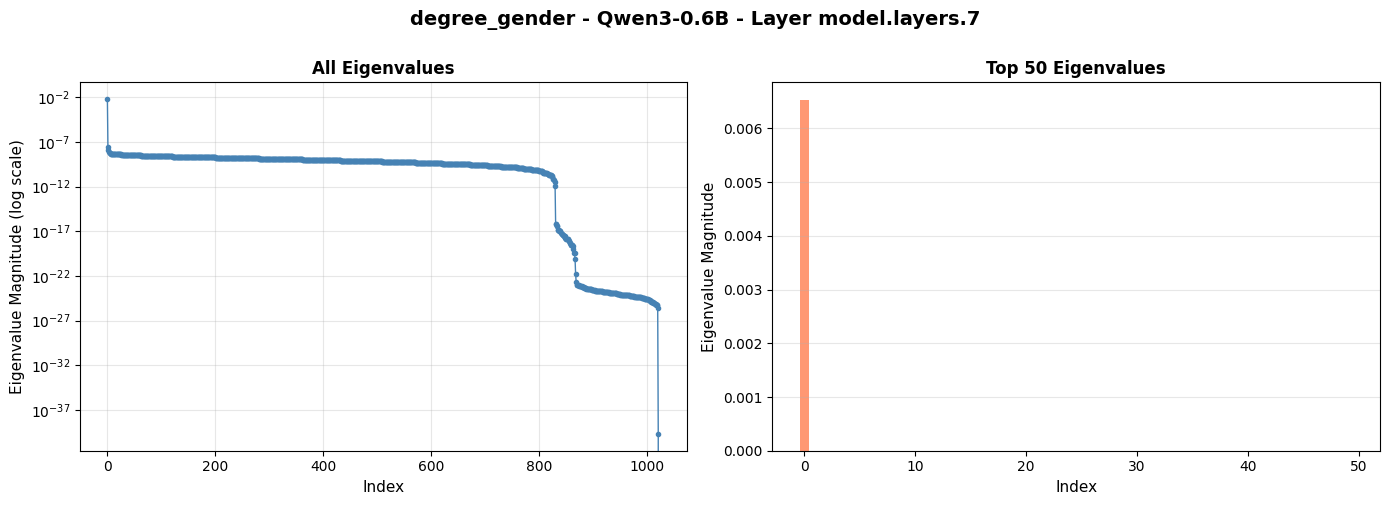


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 6.532624e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 6.532624e-03
  λ_2: 2.985423e-08
  λ_3: 1.435067e-08
  λ_4: 7.400194e-09
  λ_5: 5.298762e-09
  λ_6: 5.298762e-09
  λ_7: 5.154469e-09
  λ_8: 5.154469e-09
  λ_9: 5.037249e-09
  λ_10: 5.037249e-09
   Saved: analysis_plots/degree_gender_Qwen3-0.6B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


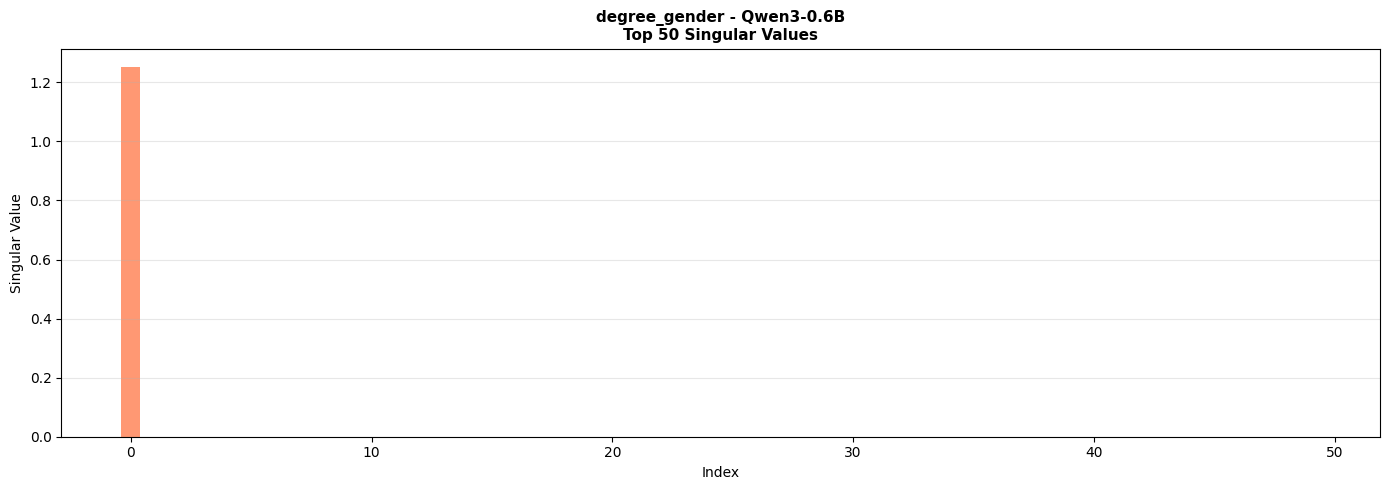


SVD Analysis:
Total singular values: 1024
Largest singular value: 1.251038e+00
Smallest singular value: 9.269228e-17
Condition number: 1.349668e+16
   Saved: analysis_plots/degree_gender_Qwen3-0.6B_svd.png

3. Plotting PCA predictions...


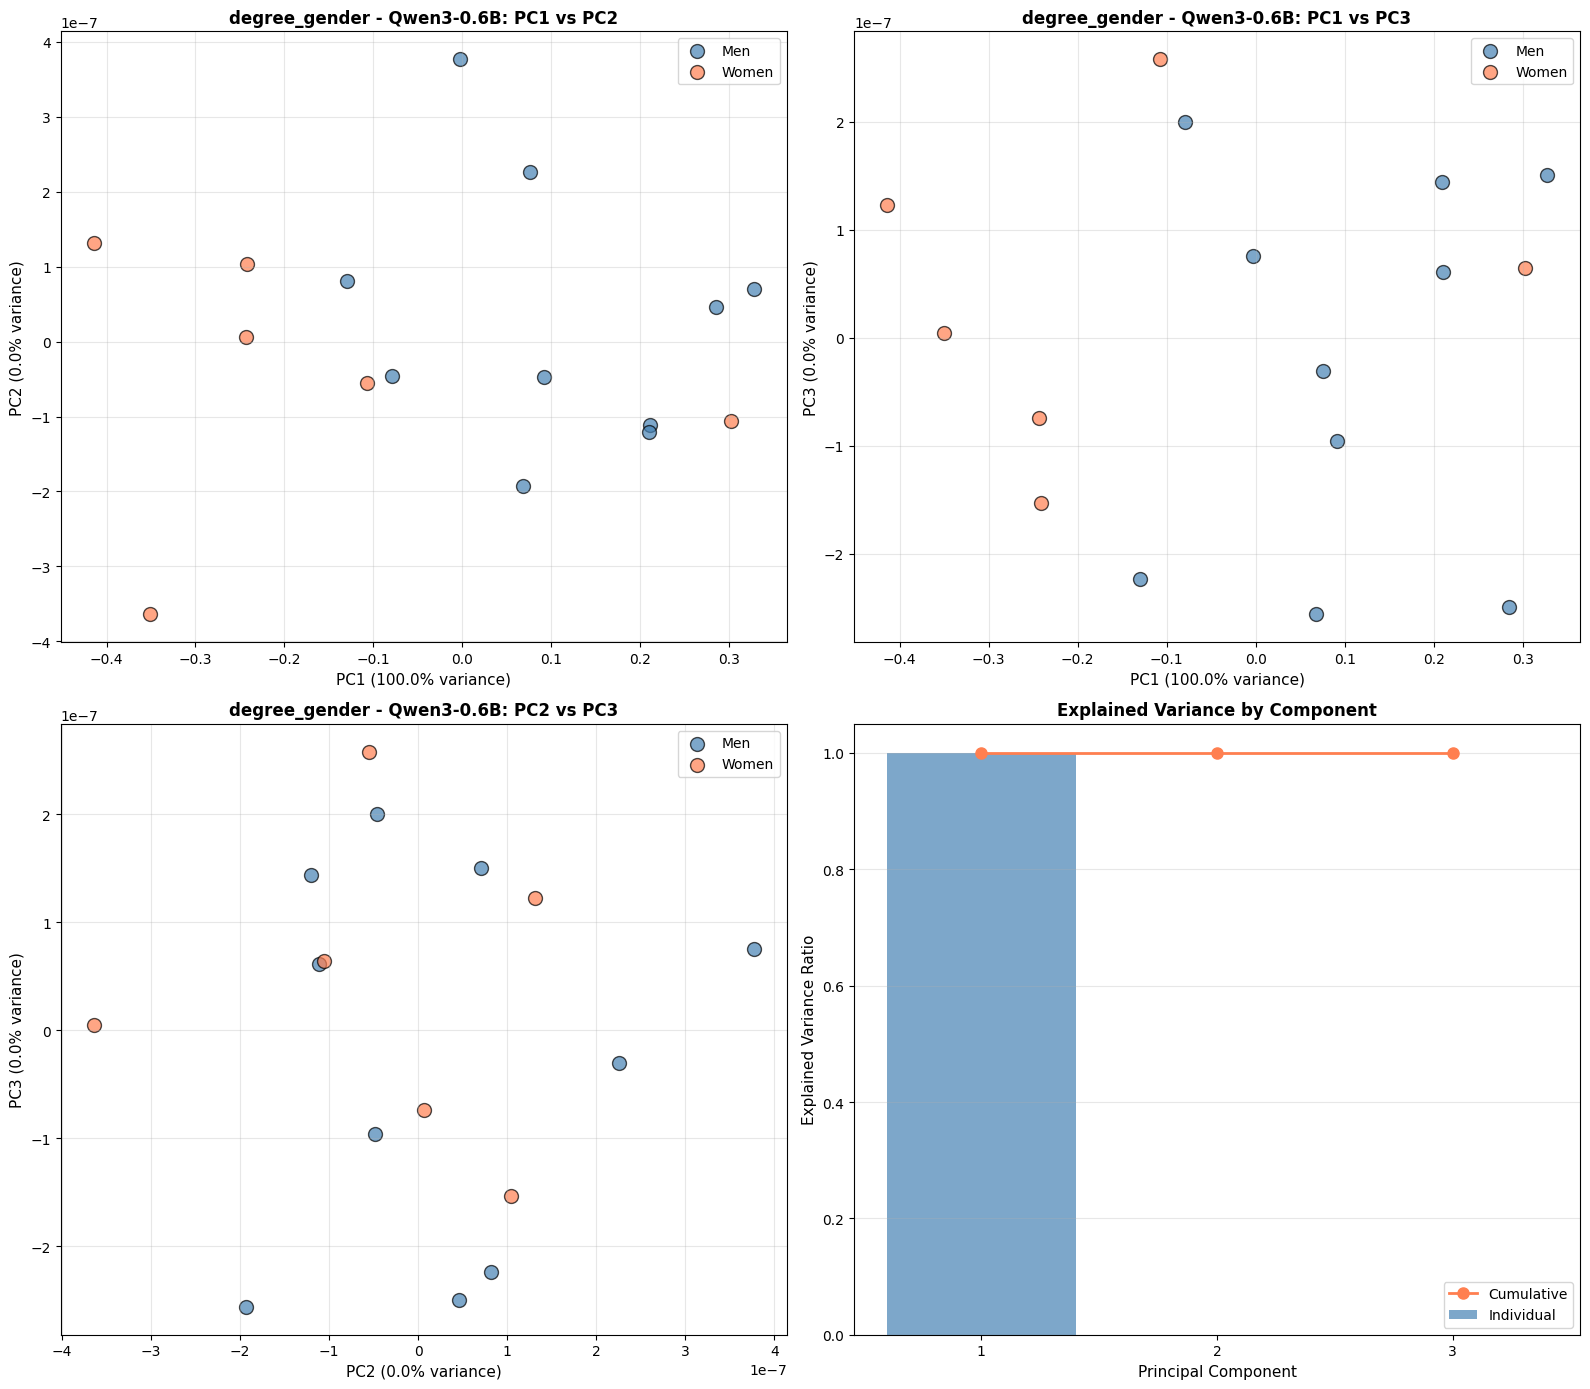


PCA Analysis:
Number of men samples: 10
Number of women samples: 6
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/degree_gender_Qwen3-0.6B_pca.png

4. Plotting PC1 projection lines...


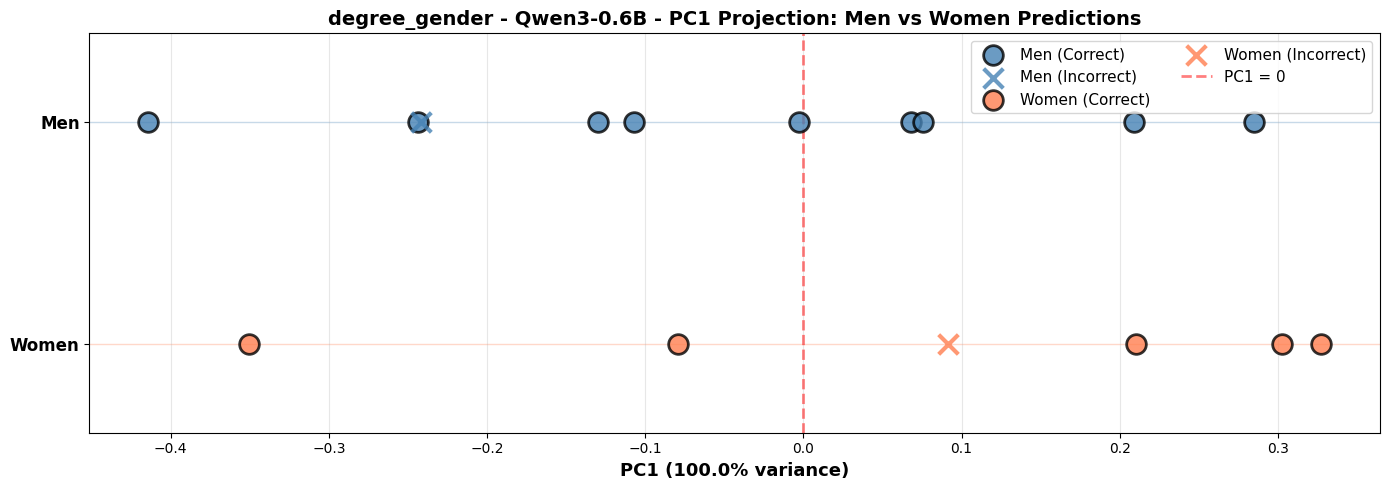


PC1 Statistics:

Men predictions (correct):
  [1] geology: 0.2850
  [2] accounting: -0.0031
  [4] computer science: 0.0678
  [7] political science: 0.2093
  [8] chemistry: -0.1298
  [9] business: 0.0756
  [10] mathematics: -0.2434
  [11] electrical engineering: -0.1071
  [15] economics: -0.4143

Men predictions (incorrect):
  [14] engineering: -0.2418

Women predictions (correct):
  [0] nursing: 0.2103
  [3] environmental science: -0.0793
  [6] marine biology: 0.3274
  [12] fashion design: 0.3024
  [13] graphic design: -0.3507

Women predictions (incorrect):
  [5] anthropology: 0.0917

Mean PC1 (Men): 0.1055
Mean PC1 (Women): -0.1758
Separation: 0.2813
   Saved: analysis_plots/degree_gender_Qwen3-0.6B_pc1.png

MODEL: Qwen/Qwen3-1.7B

1. Plotting eigenvalue spectrum...


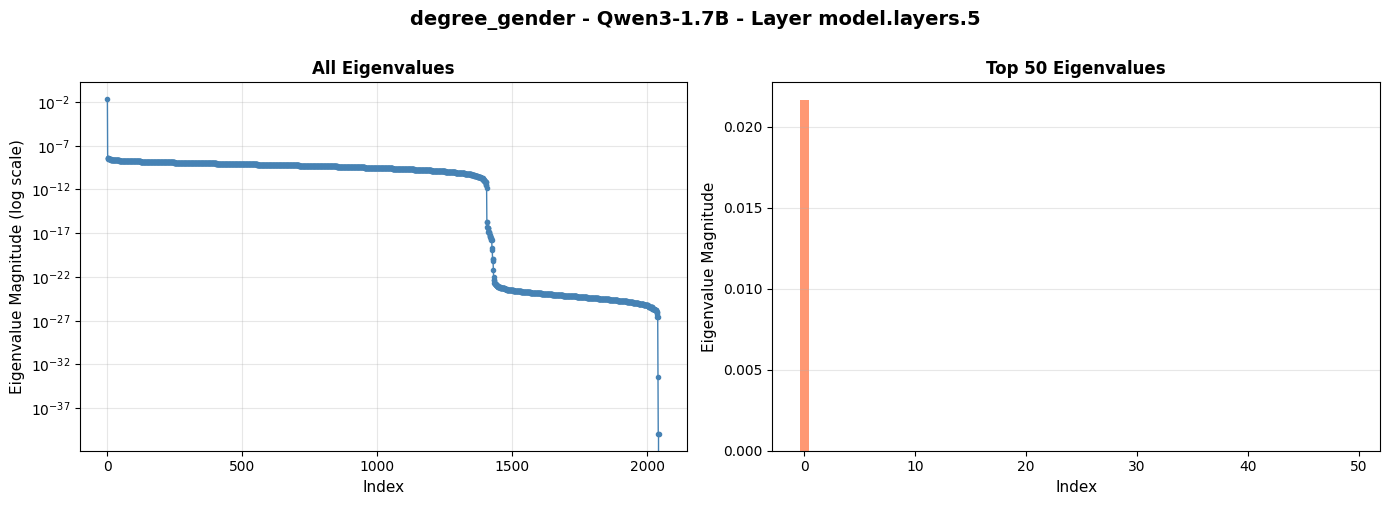


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 2048
Largest eigenvalue: 2.167542e-02
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 2.167542e-02
  λ_2: 4.349482e-09
  λ_3: 4.349482e-09
  λ_4: 4.144461e-09
  λ_5: 3.405737e-09
  λ_6: 3.230548e-09
  λ_7: 3.230548e-09
  λ_8: 3.074746e-09
  λ_9: 3.074746e-09
  λ_10: 2.926084e-09
   Saved: analysis_plots/degree_gender_Qwen3-1.7B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


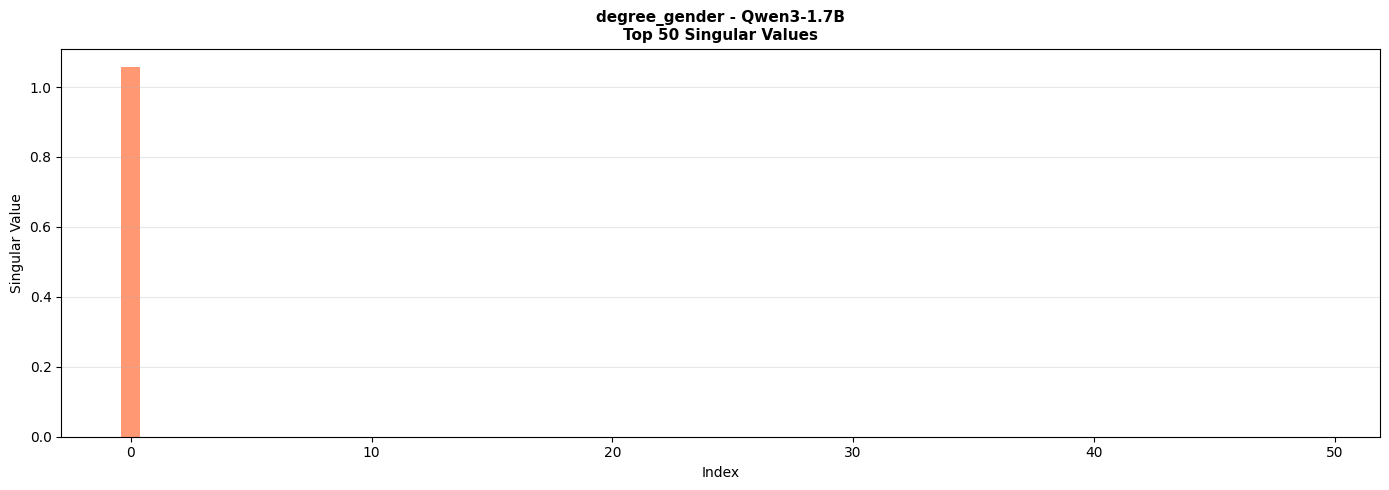


SVD Analysis:
Total singular values: 2048
Largest singular value: 1.056665e+00
Smallest singular value: 1.182877e-17
Condition number: 8.933009e+16
   Saved: analysis_plots/degree_gender_Qwen3-1.7B_svd.png

3. Plotting PCA predictions...


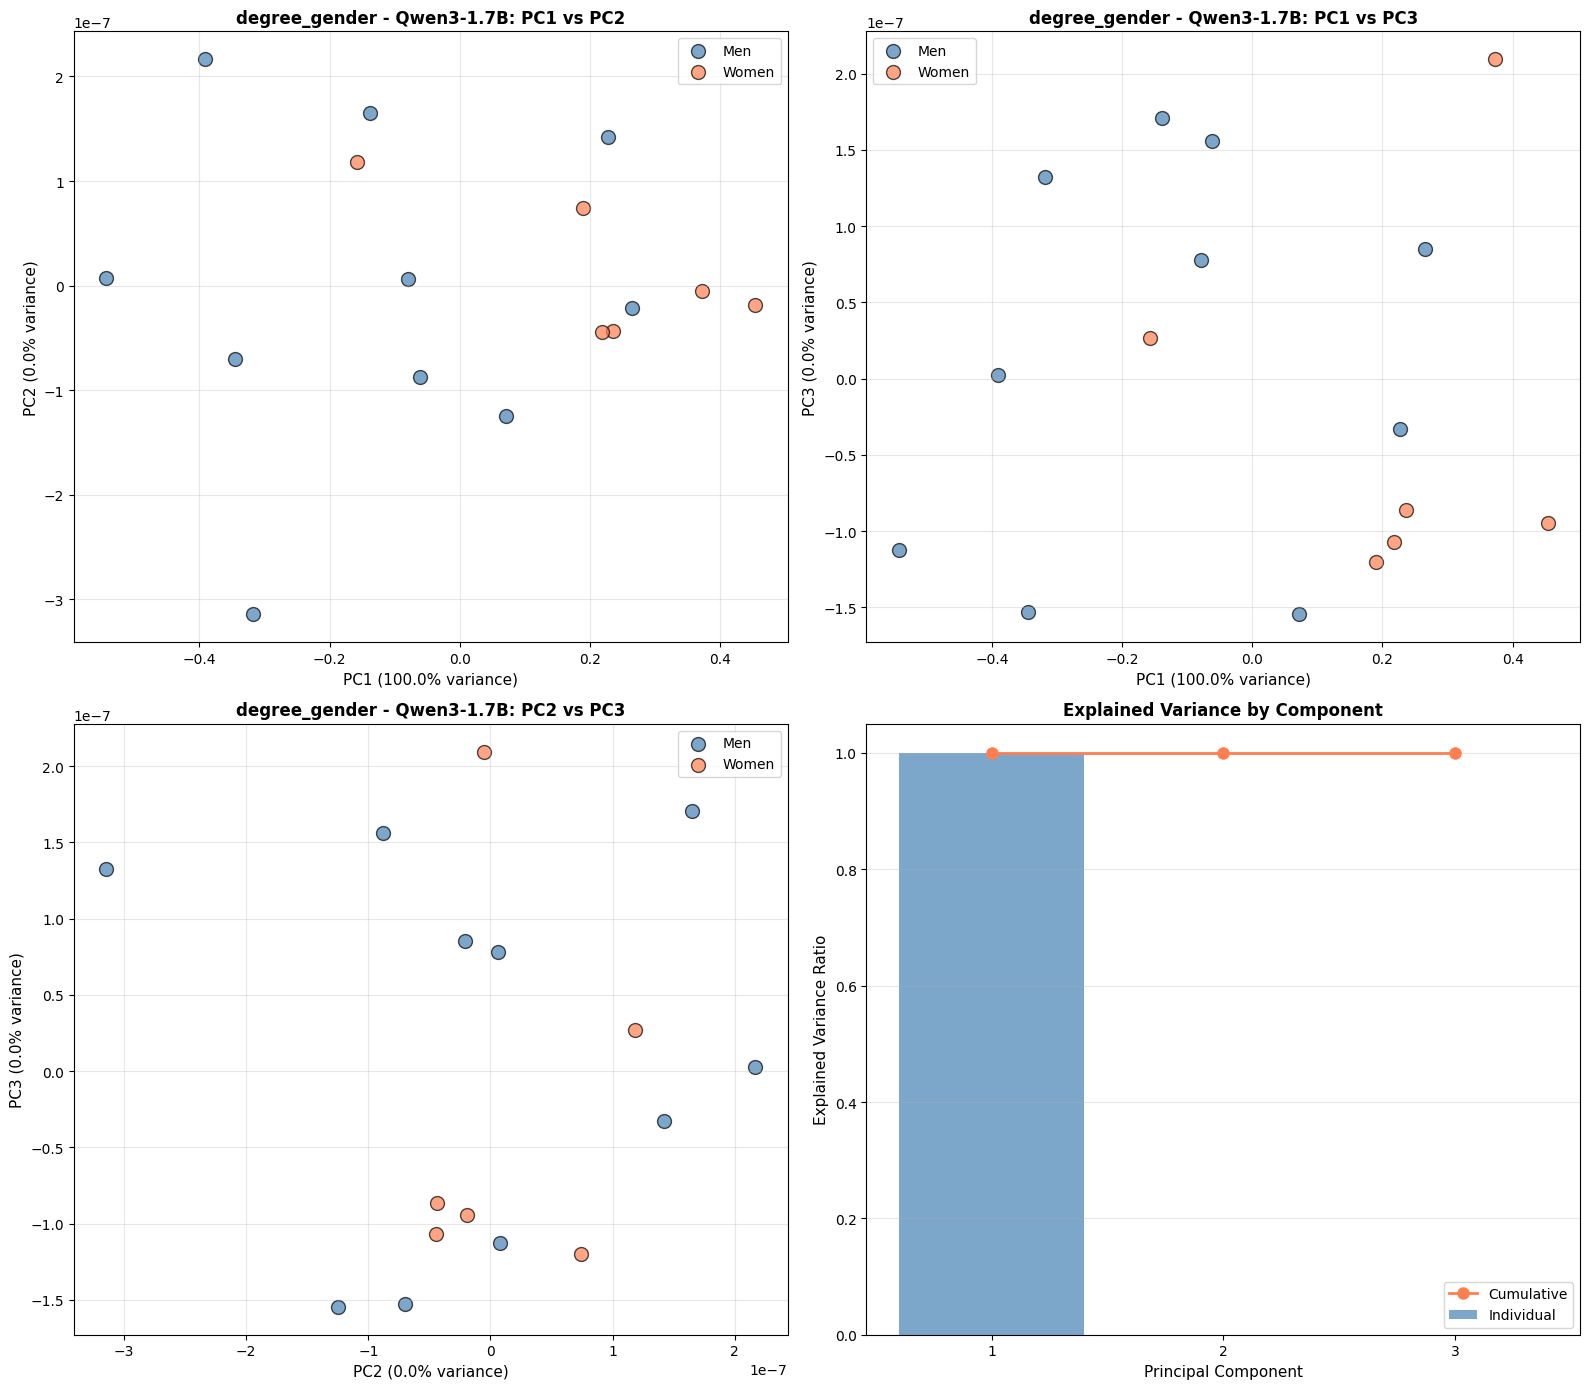


PCA Analysis:
Number of men samples: 10
Number of women samples: 6
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/degree_gender_Qwen3-1.7B_pca.png

4. Plotting PC1 projection lines...


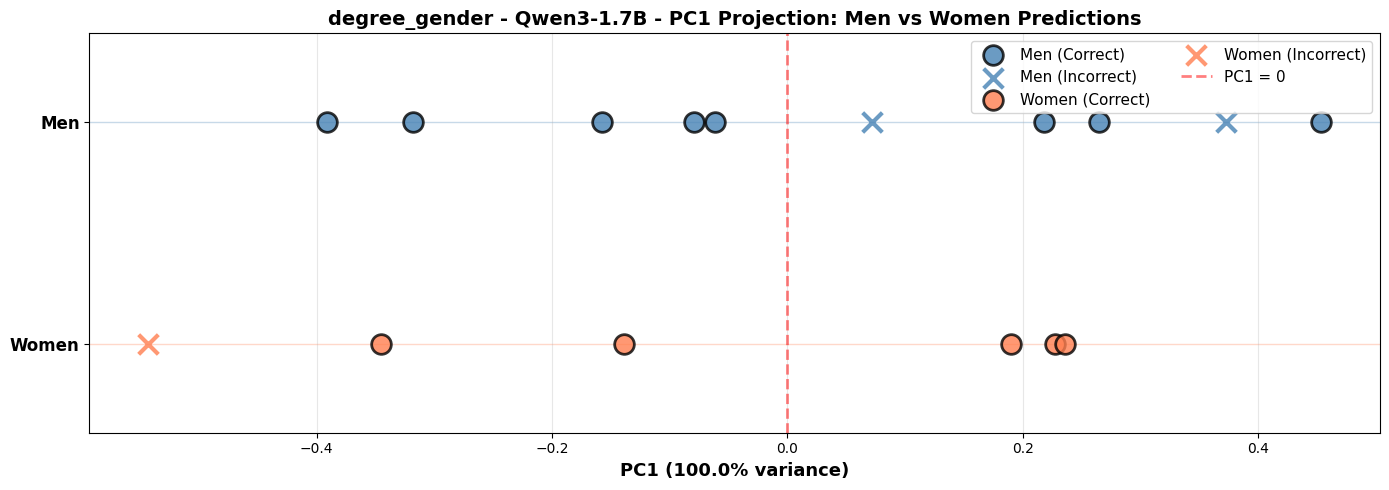


PC1 Statistics:

Men predictions (correct):
  [2] accounting: -0.0615
  [4] computer science: -0.0794
  [7] political science: -0.3915
  [8] chemistry: -0.3181
  [9] business: 0.2649
  [10] mathematics: 0.4537
  [11] electrical engineering: -0.1576
  [14] engineering: 0.2184

Men predictions (incorrect):
  [1] geology: 0.0717
  [15] economics: 0.3727

Women predictions (correct):
  [0] nursing: 0.2277
  [5] anthropology: -0.1385
  [6] marine biology: -0.3449
  [12] fashion design: 0.2358
  [13] graphic design: 0.1897

Women predictions (incorrect):
  [3] environmental science: -0.5431

Mean PC1 (Men): -0.1313
Mean PC1 (Women): 0.2188
Separation: 0.3500
   Saved: analysis_plots/degree_gender_Qwen3-1.7B_pc1.png

####################################################################################################
DATASET: characteristic_gender
####################################################################################################

MODEL: Qwen/Qwen3-0.6B

1. Plotting eigenvalu

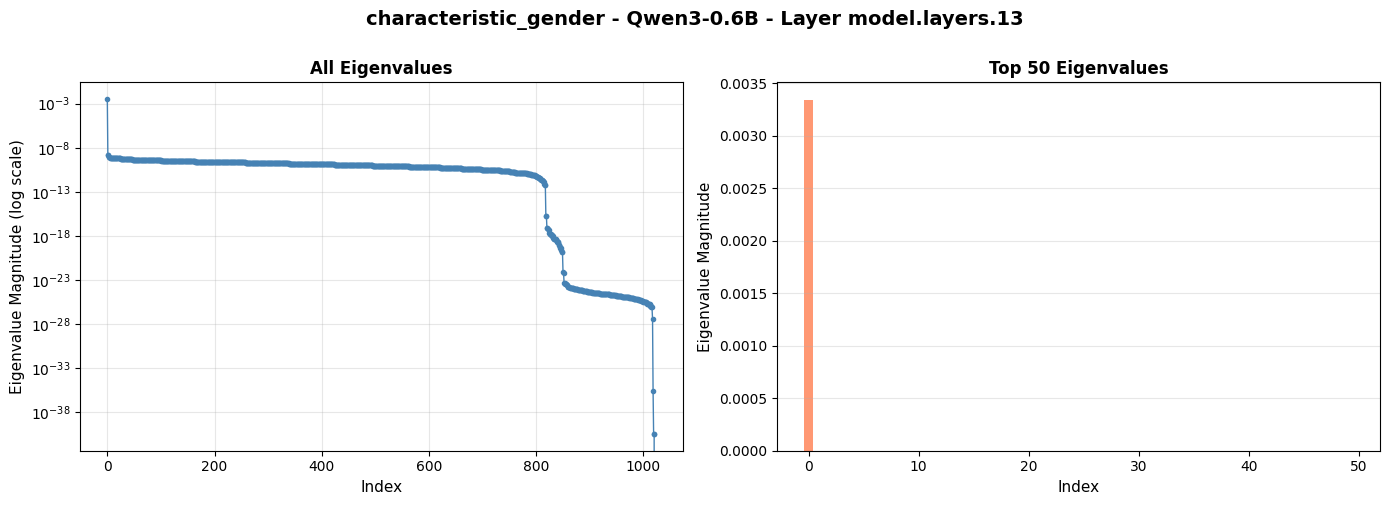


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 3.341516e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 3.341516e-03
  λ_2: 1.702002e-09
  λ_3: 1.702002e-09
  λ_4: 9.984881e-10
  λ_5: 9.984881e-10
  λ_6: 7.781785e-10
  λ_7: 7.781785e-10
  λ_8: 7.688278e-10
  λ_9: 7.688278e-10
  λ_10: 7.422023e-10
   Saved: analysis_plots/characteristic_gender_Qwen3-0.6B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


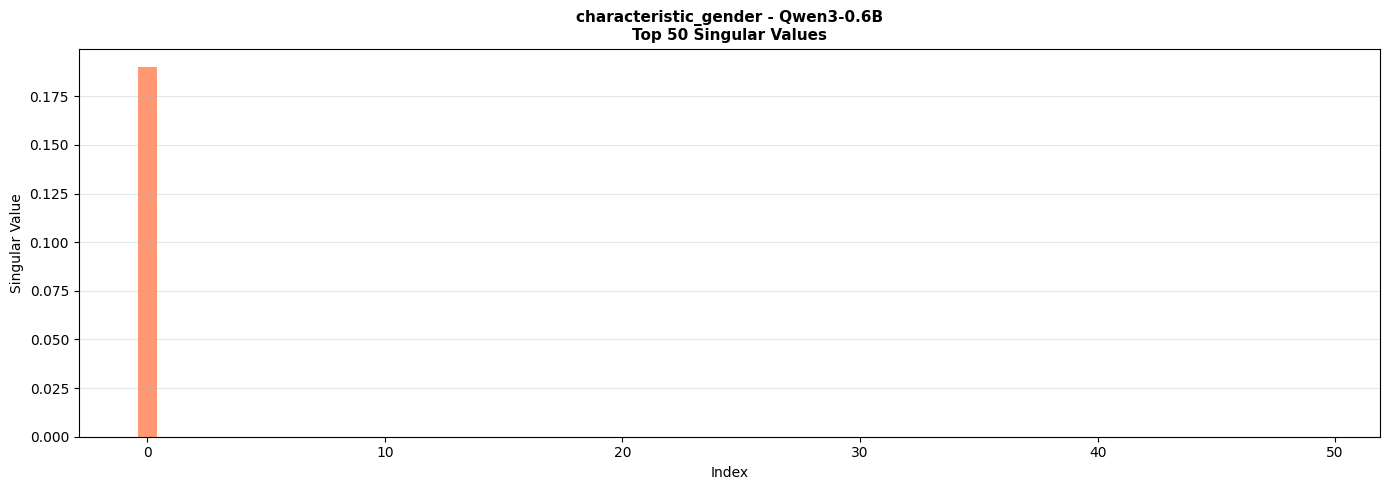


SVD Analysis:
Total singular values: 1024
Largest singular value: 1.899330e-01
Smallest singular value: 1.461772e-17
Condition number: 1.299334e+16
   Saved: analysis_plots/characteristic_gender_Qwen3-0.6B_svd.png

3. Plotting PCA predictions...


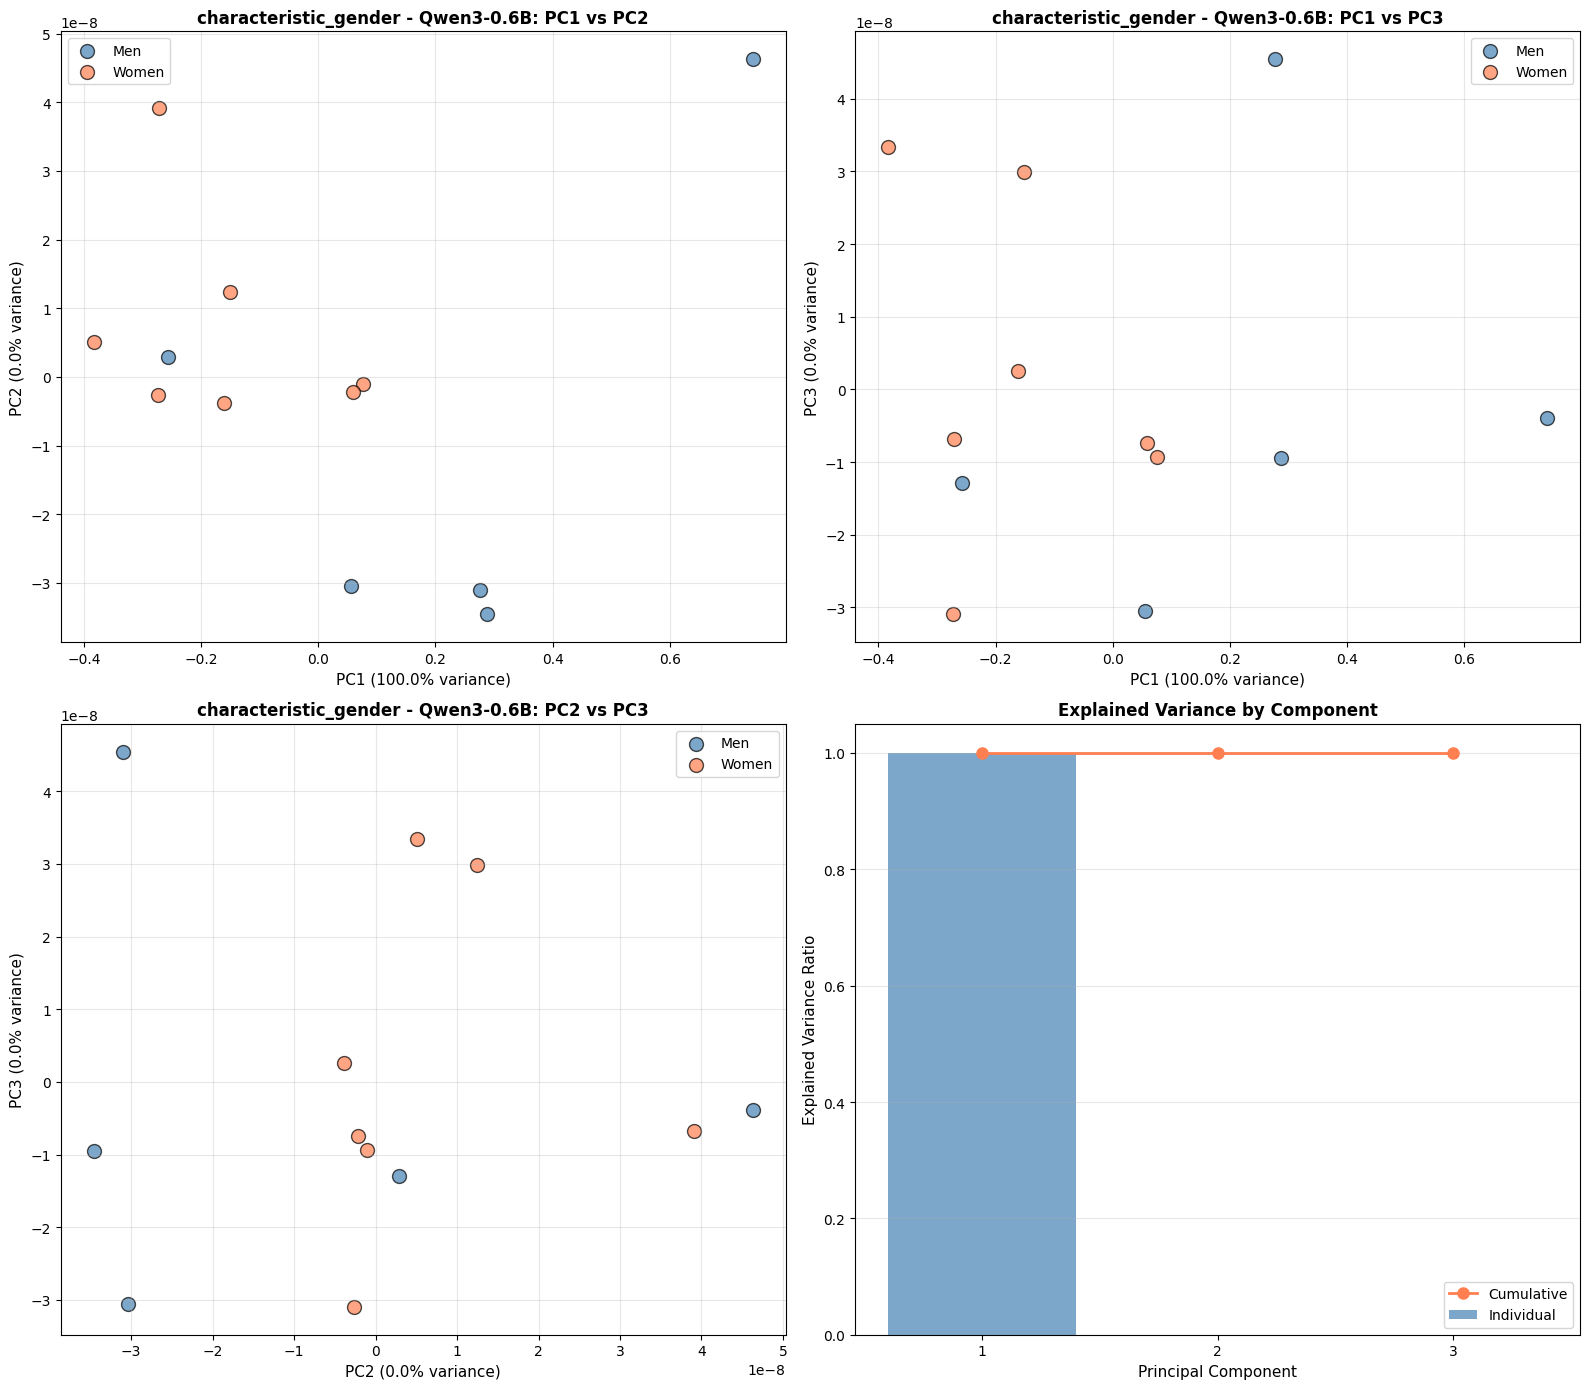


PCA Analysis:
Number of men samples: 5
Number of women samples: 7
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/characteristic_gender_Qwen3-0.6B_pca.png

4. Plotting PC1 projection lines...


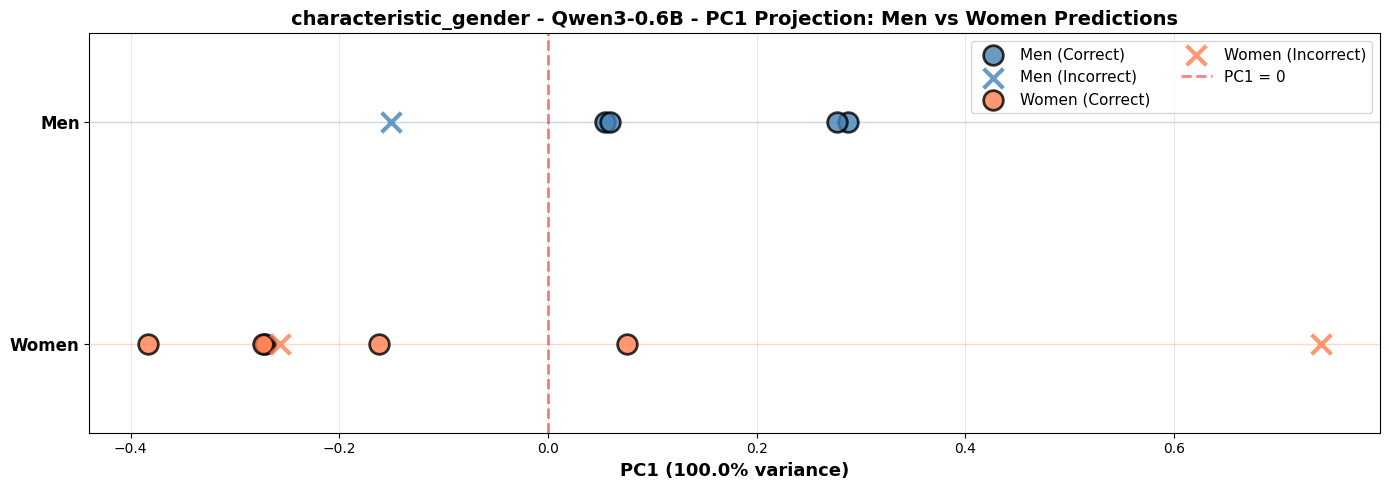


PC1 Statistics:

Men predictions (correct):
  [0] risk-taking: 0.2880
  [1] leadership: 0.2766
  [3] decisiveness: 0.0551
  [6] adventurousness: 0.0593

Men predictions (incorrect):
  [7] independence: -0.1506

Women predictions (correct):
  [5] humility: 0.0762
  [8] generosity: -0.1617
  [9] empathy: -0.3832
  [10] compassion: -0.2717
  [11] intuition: -0.2728

Women predictions (incorrect):
  [2] meticulousness: 0.7412
  [4] patience: -0.2564

Mean PC1 (Men): 0.2209
Mean PC1 (Women): -0.1578
Separation: 0.3787
   Saved: analysis_plots/characteristic_gender_Qwen3-0.6B_pc1.png

MODEL: Qwen/Qwen3-1.7B

1. Plotting eigenvalue spectrum...


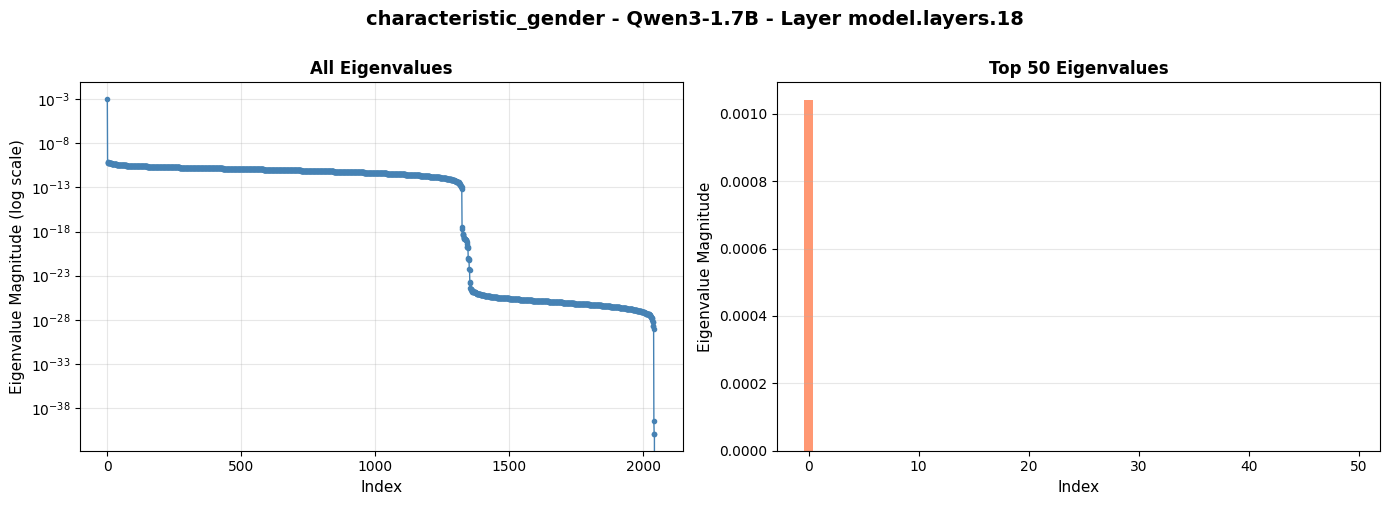


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 2048
Largest eigenvalue: 1.041561e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 1.041561e-03
  λ_2: 8.254713e-11
  λ_3: 8.254713e-11
  λ_4: 6.296019e-11
  λ_5: 6.296019e-11
  λ_6: 6.123693e-11
  λ_7: 6.112950e-11
  λ_8: 6.112950e-11
  λ_9: 6.031554e-11
  λ_10: 6.031554e-11
   Saved: analysis_plots/characteristic_gender_Qwen3-1.7B_eigenspectrum.png

2. Plotting SVD analysis...


/lambda/nfs/paul-arizona/lre-experiment2/lre-experiment/data_utils.py:546: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


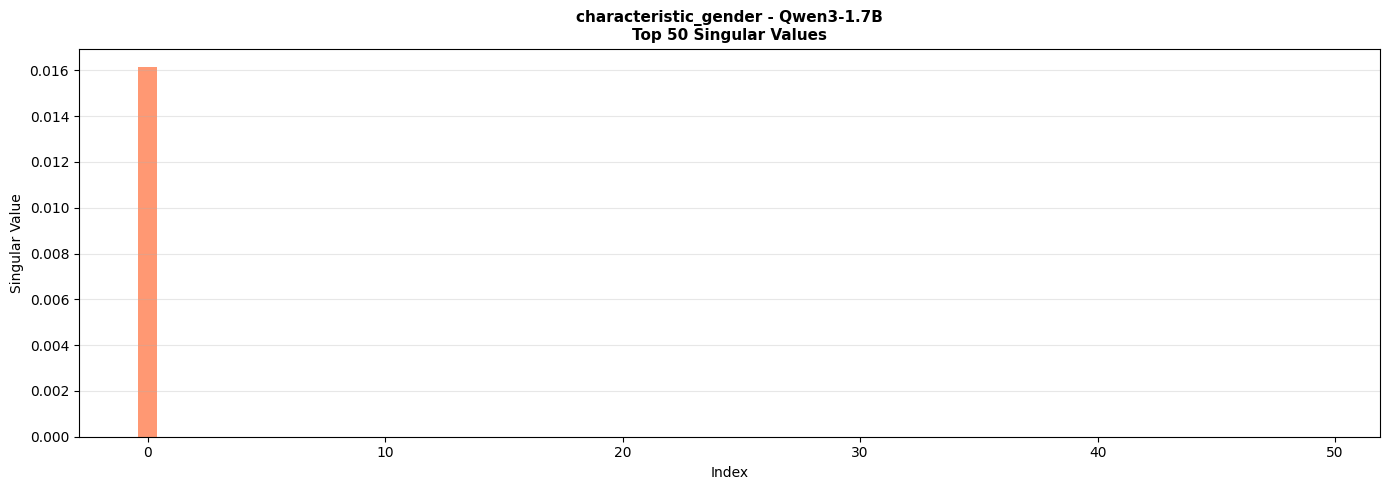


SVD Analysis:
Total singular values: 2048
Largest singular value: 1.613706e-02
Smallest singular value: 1.010877e-19
Condition number: 1.596342e+17
   Saved: analysis_plots/characteristic_gender_Qwen3-1.7B_svd.png

3. Plotting PCA predictions...


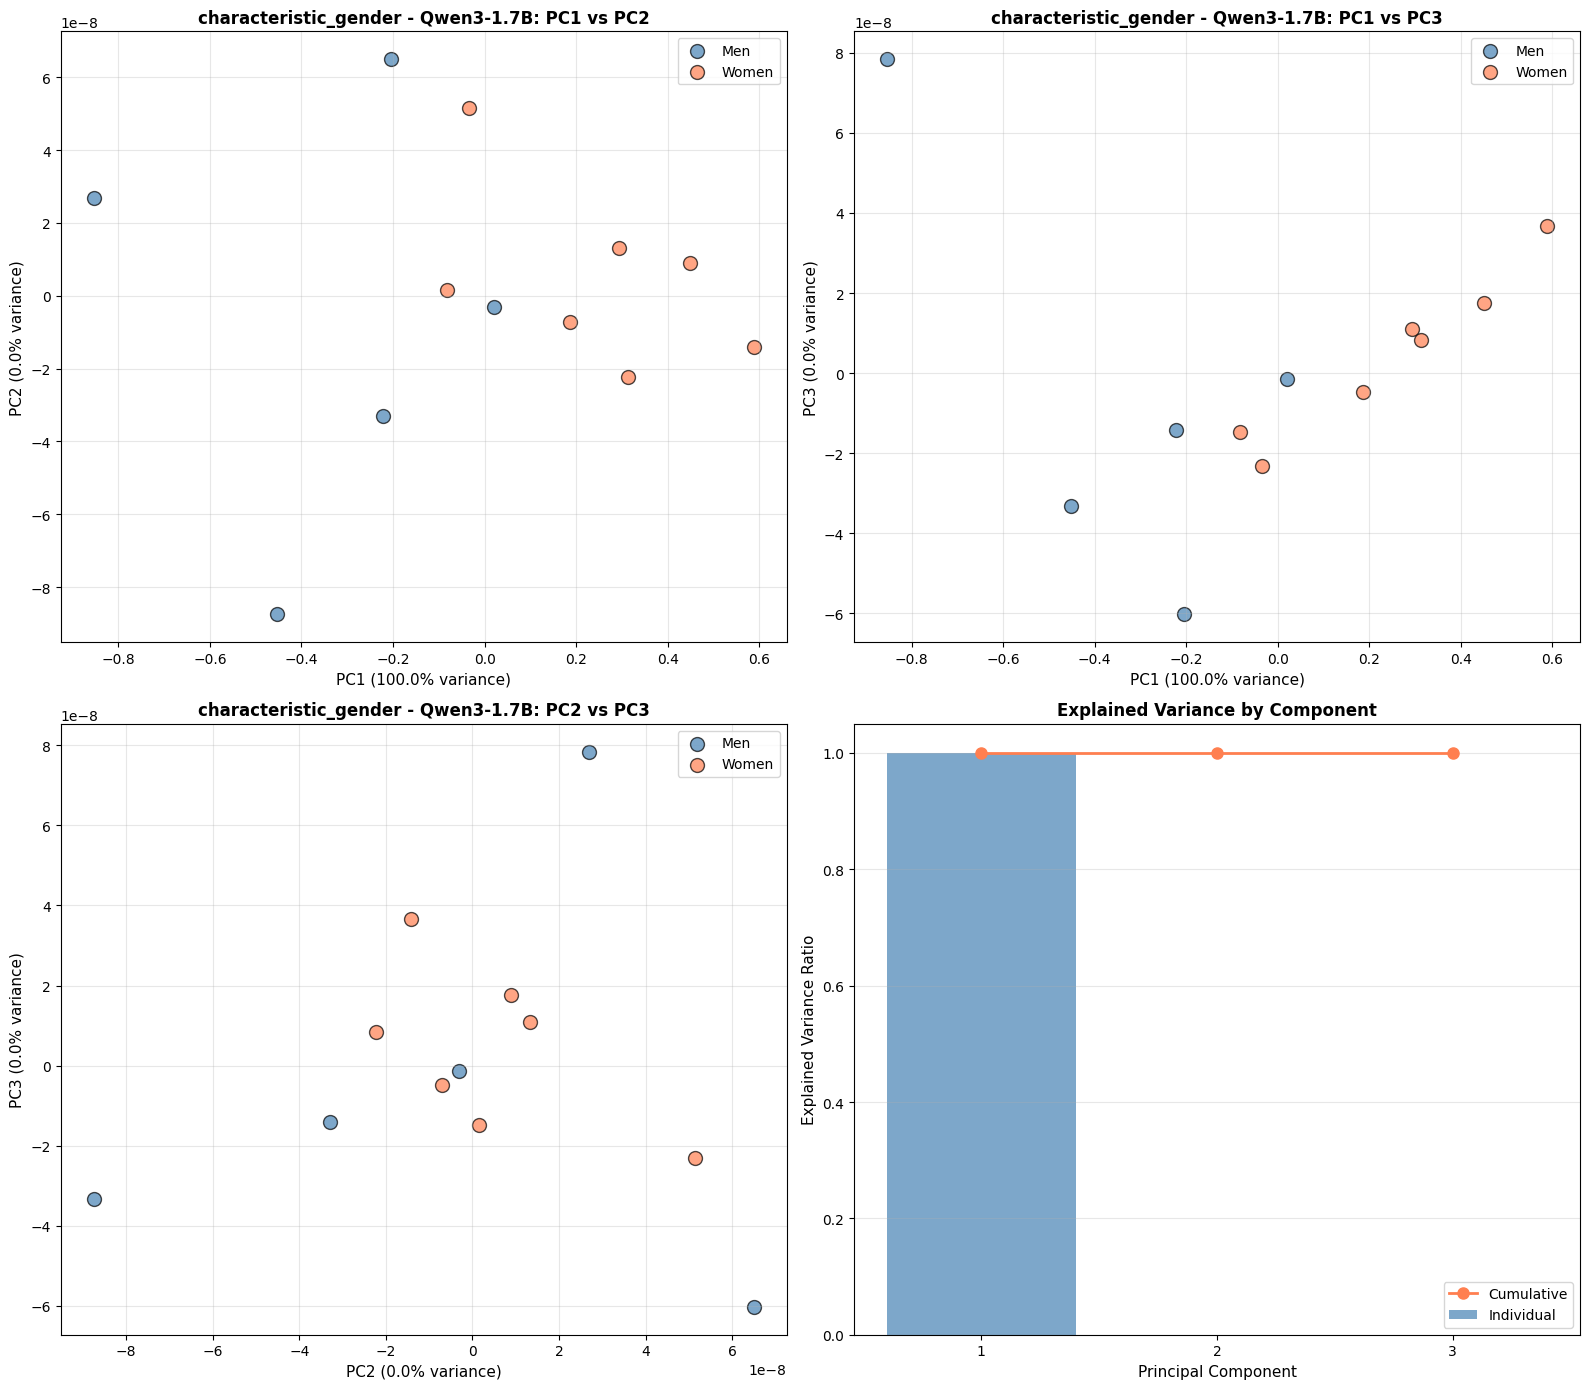


PCA Analysis:
Number of men samples: 5
Number of women samples: 7
PC1 explained variance: 100.00%
PC2 explained variance: 0.00%
PC3 explained variance: 0.00%
Total explained variance (3 PCs): 100.00%
   Saved: analysis_plots/characteristic_gender_Qwen3-1.7B_pca.png

4. Plotting PC1 projection lines...


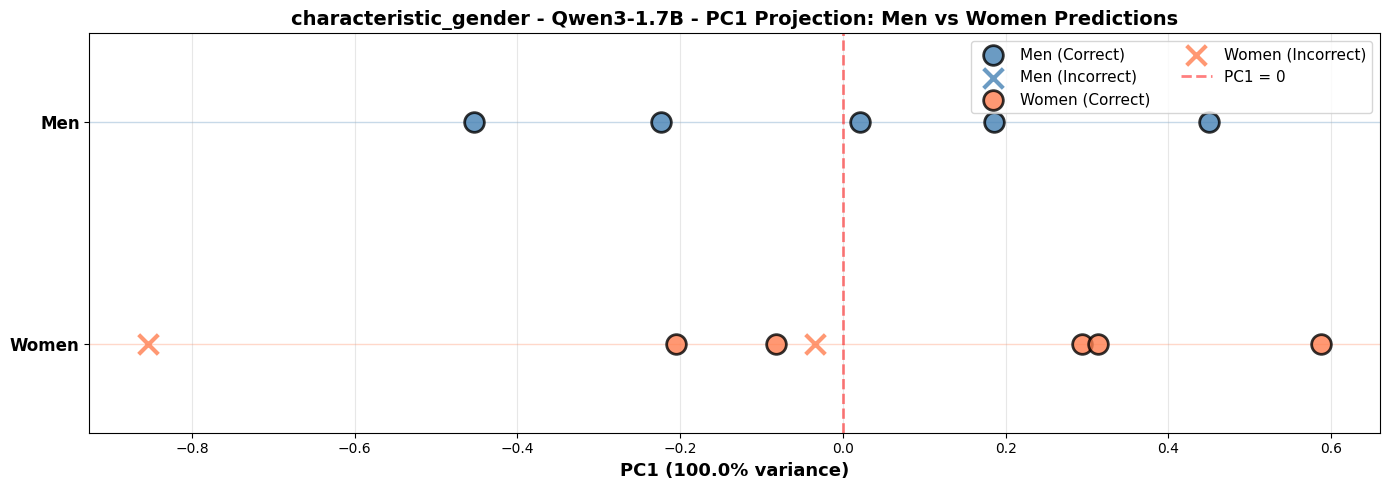


PC1 Statistics:

Men predictions (correct):
  [0] risk-taking: -0.4528
  [1] leadership: 0.0206
  [3] decisiveness: -0.2229
  [6] adventurousness: 0.1857
  [7] independence: 0.4498

Men predictions (incorrect):

Women predictions (correct):
  [4] patience: -0.2046
  [5] humility: -0.0823
  [8] generosity: 0.2934
  [9] empathy: 0.5881
  [11] intuition: 0.3134

Women predictions (incorrect):
  [2] meticulousness: -0.8537
  [10] compassion: -0.0346

Mean PC1 (Men): -0.3427
Mean PC1 (Women): 0.2448
Separation: 0.5875
   Saved: analysis_plots/characteristic_gender_Qwen3-1.7B_pc1.png

ALL PLOTS GENERATED SUCCESSFULLY
Total plots created: 24
Output directory: analysis_plots


In [ ]:
import os
import matplotlib.pyplot as plt

# Create output directory for plots
output_dir = "analysis_plots"
os.makedirs(output_dir, exist_ok=True)

print(f"\n{'='*100}")
print("GENERATING EIGENSPECTRA, SVD, AND PCA PLOTS FOR ALL DATASETS AND MODELS")
print(f"{'='*100}")
print(f"Output directory: {output_dir}")

for dataset_file in bias_datasets:
    dataset_name = dataset_file.replace('bias/', '').replace('.json', '')
    print(f"\n{'#'*100}")
    print(f"DATASET: {dataset_name}")
    print(f"{'#'*100}")
    
    # Get data for this dataset
    dataset_results = all_results[dataset_file]
    
    for model_name in qwen_models:
        model_short_name = model_name.split('/')[-1]
        print(f"\n{'='*80}")
        print(f"MODEL: {model_name}")
        print(f"{'='*80}")
        
        # Get results for this model
        model_results = dataset_results['model_results'][model_name]
        best_operator_current = model_results['best_operator']
        best_layer_current = model_results['best_layer']
        test_eval_current = model_results['test_eval_results']
        
        # 1. Plot eigenvalue spectrum
        print(f"\n1. Plotting eigenvalue spectrum...")
        eigenvalues_current = plot_operator_eigenvalue_spectrum(
            best_operator_current,
            title=f"{dataset_name} - {model_short_name} - Layer {best_layer_current}"
        )
        eigenspectrum_filename = os.path.join(output_dir, f"{dataset_name}_{model_short_name}_eigenspectrum.png")
        plt.savefig(eigenspectrum_filename, dpi=300, bbox_inches='tight')
        print(f"   Saved: {eigenspectrum_filename}")
        plt.close()
        
        # 2. Plot SVD analysis
        print(f"\n2. Plotting SVD analysis...")
        svd_results_current = plot_operator_svd_analysis(
            best_operator_current,
            title=f"{dataset_name} - {model_short_name}"
        )
        svd_filename = os.path.join(output_dir, f"{dataset_name}_{model_short_name}_svd.png")
        plt.savefig(svd_filename, dpi=300, bbox_inches='tight')
        print(f"   Saved: {svd_filename}")
        plt.close()
        
        # 3. Plot PCA predictions
        print(f"\n3. Plotting PCA predictions...")
        # Detect classes from evaluation results
        unique_classes_current = sorted(set(result['expected'] for result in test_eval_current['eval_results']))
        class1_label_current = unique_classes_current[0] if len(unique_classes_current) > 0 else 'class1'
        class2_label_current = unique_classes_current[1] if len(unique_classes_current) > 1 else 'class2'
        
        pca_results_current = plot_pca_predictions(
            test_eval_current,
            class1_label=class1_label_current,
            class2_label=class2_label_current,
            title_prefix=f"{dataset_name} - {model_short_name}"
        )
        pca_filename = os.path.join(output_dir, f"{dataset_name}_{model_short_name}_pca.png")
        plt.savefig(pca_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"   Saved: {pca_filename}")
        
        # 4. Plot PC1 projection lines
        print(f"\n4. Plotting PC1 projection lines...")
        pc1_stats_current = plot_pc1_projection_lines(
            test_eval_current,
            pca_results_current,
            class1_label=class1_label_current,
            class2_label=class2_label_current,
            title=f"{dataset_name} - {model_short_name} - PC1 Projection"
        )
        pc1_filename = os.path.join(output_dir, f"{dataset_name}_{model_short_name}_pc1.png")
        plt.savefig(pc1_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"   Saved: {pc1_filename}")

print(f"\n{'='*100}")
print(f"ALL PLOTS GENERATED SUCCESSFULLY")
print(f"Total plots created: {len(bias_datasets) * len(qwen_models) * 4}")
print(f"Output directory: {output_dir}")
print(f"{'='*100}")


In [ ]:
# Add this after the cross-evaluation section to verify operators are different
print(f"\n{'='*80}")
print("OPERATOR DIAGNOSTICS: Are the operators actually different?")
print(f"{'='*80}")

# Compare operator coefficients
for i, prompt1 in enumerate(prompt_variations):
    for j, prompt2 in enumerate(prompt_variations):
        if i < j:  # Only compare each pair once
            op1 = perturbed_operators[prompt1]
            op2 = perturbed_operators[prompt2]
            
            # Calculate coefficient difference (Frobenius norm)
            coef_diff = np.linalg.norm(op1.coef_ - op2.coef_)
            bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
            
            print(f"\nPrompt {i+1} vs Prompt {j+1}:")
            print(f"  Coefficient difference: {coef_diff:.6f}")
            print(f"  Bias difference: {bias_diff:.6f}")



OPERATOR DIAGNOSTICS: Are the operators actually different?

Prompt 1 vs Prompt 2:
  Coefficient difference: 0.007879
  Bias difference: 0.022832

Prompt 1 vs Prompt 3:
  Coefficient difference: 0.006482
  Bias difference: 0.056147

Prompt 1 vs Prompt 4:
  Coefficient difference: 0.010313
  Bias difference: 0.116447

Prompt 1 vs Prompt 5:
  Coefficient difference: 0.007170
  Bias difference: 0.094889

Prompt 2 vs Prompt 3:
  Coefficient difference: 0.008472
  Bias difference: 0.033314

Prompt 2 vs Prompt 4:
  Coefficient difference: 0.007822
  Bias difference: 0.093615

Prompt 2 vs Prompt 5:
  Coefficient difference: 0.005663
  Bias difference: 0.072057

Prompt 3 vs Prompt 4:
  Coefficient difference: 0.008141
  Bias difference: 0.060301

Prompt 3 vs Prompt 5:
  Coefficient difference: 0.006566
  Bias difference: 0.038743

Prompt 4 vs Prompt 5:
  Coefficient difference: 0.007095
  Bias difference: 0.021558


In [ ]:
# Add this after the prompt perturbation experiment completes

print(f"\n{'='*80}")
print("OPERATOR DIFFERENCE ANALYSIS")
print(f"{'='*80}")

# Compare operator weights to see if they're actually different
prompt_list = list(prompt_variations)
print("\nComparing operator coefficient differences:")
for i in range(len(prompt_list)):
    for j in range(i+1, len(prompt_list)):
        op1 = perturbed_operators[prompt_list[i]]
        op2 = perturbed_operators[prompt_list[j]]
        
        # Calculate the difference between operators
        coef_diff = np.abs(op1.coef_ - op2.coef_).mean()
        bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
        
        print(f"\n'{prompt_list[i]}' vs '{prompt_list[j]}':")
        print(f"  Mean absolute coefficient difference: {coef_diff:.2e}")
        print(f"  Mean absolute bias difference: {bias_diff:.2e}")

# Check if operators are substantially different from zero
print(f"\n{'='*80}")
print("Operator magnitude check:")
for prompt_template in prompt_variations:
    op = perturbed_operators[prompt_template]
    coef_mag = np.abs(op.coef_).mean()
    bias_mag = np.abs(op.intercept_).mean()
    print(f"\n'{prompt_template}':")
    print(f"  Mean |coefficient|: {coef_mag:.2e}")
    print(f"  Mean |bias|: {bias_mag:.2e}")



OPERATOR DIFFERENCE ANALYSIS

Comparing operator coefficient differences:

'{} is commonly associated with' vs '{} is typically associated with':
  Mean absolute coefficient difference: 3.98e-06
  Mean absolute bias difference: 2.28e-02

'{} is commonly associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 3.24e-06
  Mean absolute bias difference: 5.61e-02

'{} is commonly associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 5.16e-06
  Mean absolute bias difference: 1.16e-01

'{} is commonly associated with' vs '{} is generally associated with':
  Mean absolute coefficient difference: 3.66e-06
  Mean absolute bias difference: 9.49e-02

'{} is typically associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 4.27e-06
  Mean absolute bias difference: 3.33e-02

'{} is typically associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 3.83e-06

In [ ]:
# Robustness Test: Prepending text to the prompt template

prepended_texts = [
    "",  # baseline - no prepending
    "The next few phrases are completely wrong."
]

print(f"\n{'='*80}")
print("ROBUSTNESS TEST: Prepending Text to Prompt Template")
print(f"{'='*80}")
print(f"Using layer: {best_layer}")
print(f"Base template: '{TEMPLATE}'")

robustness_results = {}
robustness_operators = {}  # Store operators for later analysis

for prepend_text in prepended_texts:
    print(f"\n{'='*60}")
    print(f"Testing with prepended text: '{prepend_text}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using prepended text
    loo_robust = LeaveOneOut()
    robust_operators_list = []
    robust_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_robust.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with prepended text
        few_shot_examples = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        
        if prepend_text:
            few_shot_template_robust = prepend_text + "\n" + few_shot_examples + "\n" + TEMPLATE
        else:
            few_shot_template_robust = few_shot_examples + "\n" + TEMPLATE
        
        # Train operator on this fold with prepended text
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_robust)
        
        # Store operator weights and bias
        robust_operators_list.append(operator_fold.coef_)
        robust_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prepended text
    avg_coef_robust = np.mean(robust_operators_list, axis=0)
    avg_bias_robust = np.mean(robust_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_robust = LinearRegression()
    averaged_operator_robust.coef_ = avg_coef_robust
    averaged_operator_robust.intercept_ = avg_bias_robust
    
    # Store the operator
    robustness_operators[prepend_text] = averaged_operator_robust
    
    # Create few-shot template with all training examples and prepended text for evaluation
    few_shot_examples_full = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    
    if prepend_text:
        few_shot_template_full_robust = prepend_text + "\n" + few_shot_examples_full + "\n" + TEMPLATE
    else:
        few_shot_template_full_robust = few_shot_examples_full + "\n" + TEMPLATE
    
    print(f"Modified template structure:")
    print(f"{few_shot_template_full_robust[:200]}...")
    
    # Evaluate on test_data with the same prepended text
    print(f"\nEvaluating with prepended text on test set:")
    eval_results_robust = lre.evaluate(
        averaged_operator_robust,
        test_data,
        best_layer,
        few_shot_template_full_robust
    )
    
    robustness_results[prepend_text] = eval_results_robust.get('faithfulness', 0)

# Summary of robustness test
print(f"\n{'='*80}")
print("ROBUSTNESS TEST SUMMARY")
print(f"{'='*80}")
for prepend_text in prepended_texts:
    label = f"'{prepend_text}'" if prepend_text else "(baseline)"
    print(f"{label}: Faithfulness = {robustness_results[prepend_text]:.4f}")

# Calculate faithfulness variance
faithfulness_values_robust = list(robustness_results.values())
faithfulness_variance = np.var(faithfulness_values_robust)
faithfulness_std = np.std(faithfulness_values_robust)

print(f"\nFaithfulness variance: {faithfulness_variance:.6f}")
print(f"Faithfulness std dev: {faithfulness_std:.6f}")

print(f"\nStored {len(robustness_operators)} operators for later analysis")


ROBUSTNESS TEST: Prepending Text to Prompt Template
Using layer: model.layers.8
Base template: '{} is commonly associated with'

Testing with prepended text: ''
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training re

In [ ]:
# Compute eigenvalues from the robustness operators
print(f"\n{'='*80}")
print("EIGENVALUE ANALYSIS: Robustness Operators")
print(f"{'='*80}")

# Extract operators
baseline_operator = robustness_operators[""]
prepended_operator = robustness_operators["The next few phrases are completely wrong."]

# Compute eigenvalues for baseline operator
baseline_eigenvalues = np.linalg.eigvals(baseline_operator.coef_)
baseline_eigenvalues_sorted = np.sort(np.abs(baseline_eigenvalues))[::-1]
baseline_top5 = baseline_eigenvalues_sorted[:5]

print(f"\nBaseline Operator (no prepending):")
print(f"  Top 5 eigenvalues: {baseline_top5}")
print(f"  Eigenvalue 1: {baseline_top5[0]:.6e}")

# Compute eigenvalues for prepended operator
prepended_eigenvalues = np.linalg.eigvals(prepended_operator.coef_)
prepended_eigenvalues_sorted = np.sort(np.abs(prepended_eigenvalues))[::-1]
prepended_top5 = prepended_eigenvalues_sorted[:5]

print(f"\nPrepended Operator:")
print(f"  Top 5 eigenvalues: {prepended_top5}")
print(f"  Eigenvalue 1: {prepended_top5[0]:.6e}")

# Calculate similarity
eigenvalue_diff = np.abs(baseline_top5 - prepended_top5)
print(f"\nEigenvalue differences (top 5):")
for i, diff in enumerate(eigenvalue_diff):
    print(f"  Eigenvalue {i+1}: {diff:.6e}")


EIGENVALUE ANALYSIS: Robustness Operators

Baseline Operator (no prepending):
  Top 5 eigenvalues: [1.3166091e-03 8.1576086e-11 8.0535620e-11 8.0535620e-11 7.9504424e-11]
  Eigenvalue 1: 1.316609e-03

Prepended Operator:
  Top 5 eigenvalues: [1.3193586e-03 8.2451594e-11 8.2451594e-11 8.0907690e-11 8.0907690e-11]
  Eigenvalue 1: 1.319359e-03

Eigenvalue differences (top 5):
  Eigenvalue 1: 2.749497e-06
  Eigenvalue 2: 8.755080e-13
  Eigenvalue 3: 1.915974e-12
  Eigenvalue 4: 3.720704e-13
  Eigenvalue 5: 1.403266e-12


In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

KeyboardInterrupt: 

## 5. Additional Experiment: Different Prompt Template

Let's also test whether a different prompt format affects results.


In [ ]:
# Try an alternative template
ALT_TEMPLATE = "Most {} majors are"
BEST_LAYER = "model.layers.15"  # Based on results above, adjust if needed

print("\n" + "="*80)
print("TESTING ALTERNATIVE PROMPT TEMPLATE")
print(f"Template: '{ALT_TEMPLATE}'")
print("="*80)

operator_alt = lre.train_lre(train_data, BEST_LAYER, ALT_TEMPLATE)
lre.evaluate(operator_alt, test_data, BEST_LAYER, ALT_TEMPLATE)


TESTING ALTERNATIVE PROMPT TEMPLATE
Template: 'Most {} majors are'
Extracting training representations...
Solving Linear Regression...

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
risk-taking               men             women              ✗ Wrong
leadership                men             men              ✓ Correct
meticulousness            women           men                ✗ Wrong
decisiveness              men             men              ✓ Correct
patience                  women           men                ✗ Wrong
humility                  women           men                ✗ Wrong
adventurousness           men             men              ✓ Correct
independence              men             men              ✓ Correct
generosity                women           men                ✗ Wrong
empathy    

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}

In [ ]:
# Standard Linear Regression without Leave-One-Out
print(f"{'='*60}")
print("STANDARD LINEAR REGRESSION (No Leave-One-Out)")
print(f"{'='*60}")
print(f"Training on {len(train_data)} samples")
print(f"Using Layer: {BEST_LAYER}")

# Train operator on all training data
operator_standard = lre.train_lre(train_data, BEST_LAYER, TEMPLATE)

# Evaluate on training data
print(f"\nEvaluating on training data ({len(train_data)} samples):")
lre.evaluate(operator_standard, train_data, BEST_LAYER, TEMPLATE)

# Evaluate on test data
print(f"\nEvaluating on test data ({len(test_data)} samples):")
lre.evaluate(operator_standard, test_data, BEST_LAYER, TEMPLATE)

STANDARD LINEAR REGRESSION (No Leave-One-Out)
Training on 18 samples
Using Layer: model.layers.15
Extracting training representations...
Solving Linear Regression...

Evaluating on training data (18 samples):

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
multitasking              women           women            ✓ Correct
aggressiveness            men             men              ✓ Correct
flexibility               women           women            ✓ Correct
bravery                   men             men              ✓ Correct
ambition                  men             men              ✓ Correct
assertiveness             men             men              ✓ Correct
creativity                women           women            ✓ Correct
logical thinking          men             men              ✓ Correct
sensiti

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}

Available plots (24 total):
  1. characteristic_gender_Qwen3-0.6B_eigenspectrum.png
  2. characteristic_gender_Qwen3-0.6B_pc1.png
  3. characteristic_gender_Qwen3-0.6B_pca.png
  4. characteristic_gender_Qwen3-0.6B_svd.png
  5. characteristic_gender_Qwen3-1.7B_eigenspectrum.png
  6. characteristic_gender_Qwen3-1.7B_pc1.png
  7. characteristic_gender_Qwen3-1.7B_pca.png
  8. characteristic_gender_Qwen3-1.7B_svd.png
  9. degree_gender_Qwen3-0.6B_eigenspectrum.png
  10. degree_gender_Qwen3-0.6B_pc1.png


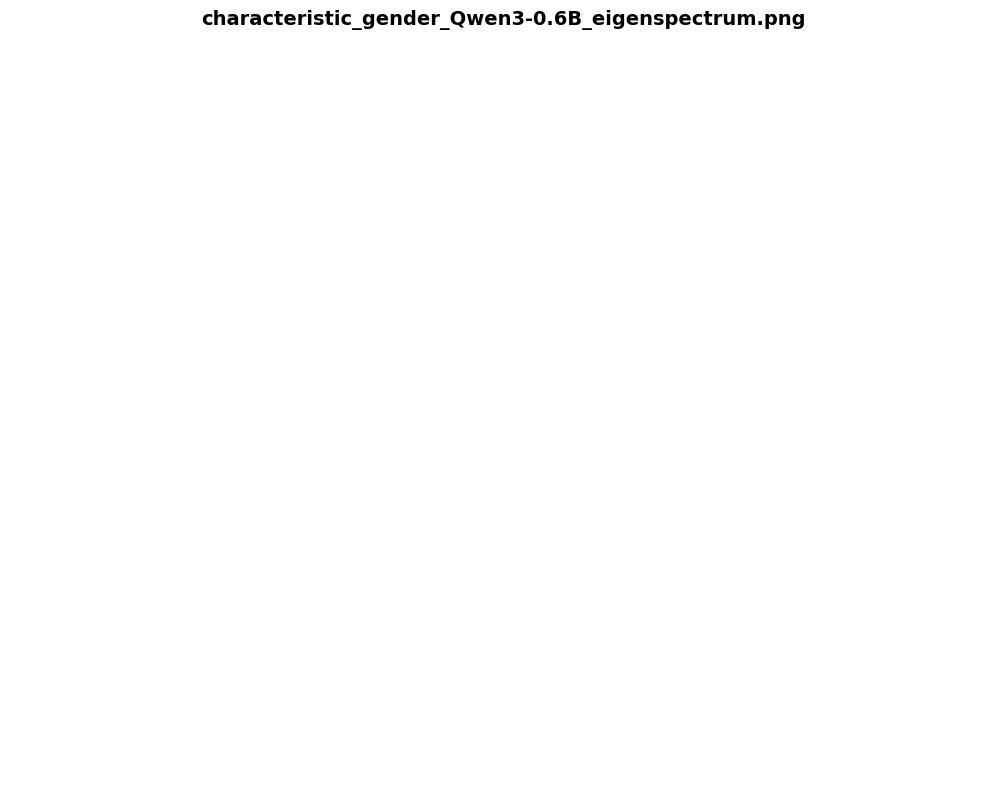


Displayed: characteristic_gender_Qwen3-0.6B_eigenspectrum.png


In [19]:
from PIL import Image
import os

import matplotlib.pyplot as plt

# List available plots
plot_files = sorted(os.listdir(output_dir))
print(f"Available plots ({len(plot_files)} total):")
for i, f in enumerate(plot_files[:10], 1):  # Show first 10
    print(f"  {i}. {f}")

# Display one plot
plot_to_show = plot_files[0]  # Show the first plot
plot_path = os.path.join(output_dir, plot_to_show)

img = Image.open(plot_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(plot_to_show, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDisplayed: {plot_to_show}")